#### Bibliotecas

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import os
import re
import rasterio
from rasterio.mask import mask
from tqdm import tqdm
import networkx as nx
import itertools
import time
from geopy.distance import great_circle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from shapely.geometry import Point
import matplotlib.patches as mpatches



#### Par√¢metros

In [2]:
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True

# Diret√≥rios e configura√ß√µes
output_folder = r'/Volumes/MiniArmstro/Resultados'

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em mil√≠metros, mas convertido para metros, em fun√ß√£o do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em mil√≠metros, mas convertido para metros.

# Considerando que a primeira linha cont√©m os cabe√ßalhos e as zonas come√ßam de 1
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/Tabelas_Site_OD2023_120225.xlsx'
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, sheet_name='tab25', index_col=0)
# Exibir as primeiras linhas do DataFrame para verifica√ß√£o
#print(matriz_od_25.head())

blue = "\033[34m"
reset = "\033[0m"

#### Definindo os boundary boxes

In [3]:
# Carregar o arquivo CSV com as subprefeituras selecionadas
df_subprefeituras = pd.read_csv("resultados_ordenados_alagamentos.csv")

# Selecionar as 10 subprefeituras com maior √≠ndice de alagamento
df_sp_lista = df_subprefeituras.sort_values(by="M√©dia", ascending=False).head(10)
#TODO Explicar bem esse crit√©rio dentro do cap√≠tulo de m√©todo

# Carregar o shapefile das subprefeituras
gdf = gpd.read_file(subprefeituras_shp)

# Filtrar o GeoDataFrame para manter apenas as subprefeituras da lista
gdf_sp_filtrado = gdf[gdf["sp_nome"].isin(df_sp_lista["sp_nome"])]

# Salvar em disco (GeoPackage e Parquet)
#bbox_gdf.to_file("bounding_boxes.gpkg", driver="GPKG")
#bbox_gdf.to_parquet("bounding_boxes.parquet")

print("Bounding boxes geradas com sucesso!")

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:31983")  # UTM Zone 23S, southern hemisphere

# Atribui√ß√£o do esquema de proje√ß√£o
gdf_sp_filtrado = gdf_sp_filtrado.set_crs(utm_crs)

# Verificar o CRS atual
print("CRS Atual:", gdf_sp_filtrado.crs)

# Calcular a √°rea em km¬≤
gdf_sp_filtrado["√Årea_km2"] = (gdf_sp_filtrado.area / 1e6).round(2)  # Convertendo de m¬≤ para km¬≤

# Exibir os 10 primeiros valores
gdf_sp_filtrado[["sp_nome", "√Årea_km2"]]


Bounding boxes geradas com sucesso!
CRS Atual: EPSG:31983


sp_nome  √Årea_km2
1     CASA VERDE-CACHOEIRINHA     27.23
2                        LAPA     40.64
4                          SE     26.66
5            SANTANA-TUCURUVI     35.78
6                   PINHEIROS     31.99
8   VILA MARIA-VILA GUILHERME     26.90
9                       MOOCA     36.04
14                 SAO MIGUEL     26.15
16  ARICANDUVA-FORMOSA-CARRAO     22.33
25                SANTO AMARO     37.74

In [4]:
# Explorar o mapa diretamente no Jupyter Notebook
gdf_sp_filtrado.explore(
    column="sp_nome",  # Colore cada bounding box de forma diferente
    cmap="Set1",  # Escolhe uma paleta de cores
    tooltip="sp_nome",  # Mostra o nome da subprefeitura ao passar o mouse
    popup=True,  # Exibe mais detalhes ao clicar
    tiles="CartoDB positron"  # Define o mapa base
)

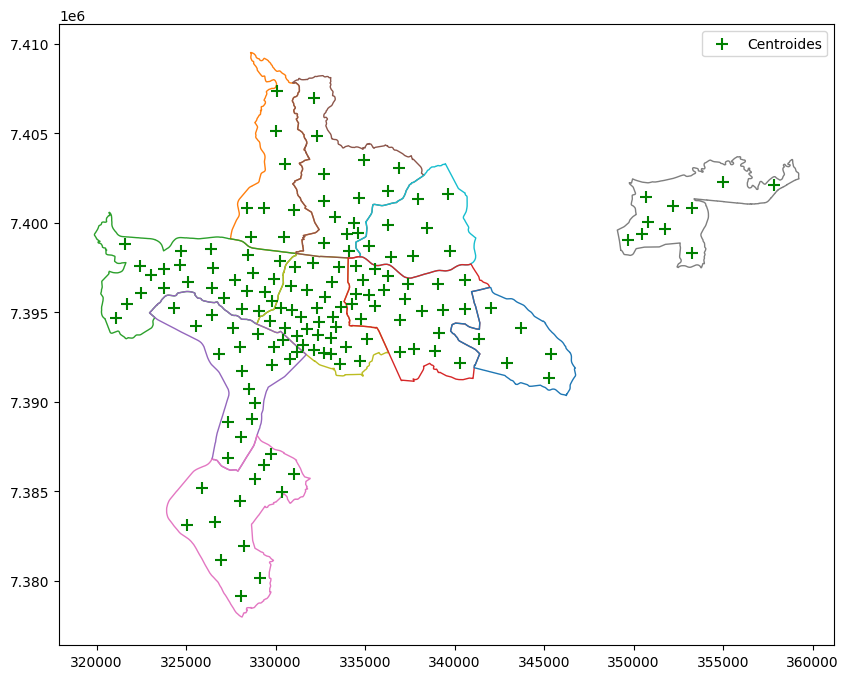

In [5]:
gdf_zonas_OD_2023 = gpd.read_file(zonas_shp_OD_2023)

# Atribui√ß√£o do esquema de proje√ß√£o
gdf_zonas_OD_2023_utm = gdf_zonas_OD_2023.to_crs(utm_crs)

# Filtrando para o mun√≠cipio de S√£o Paulo
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_2023_utm[gdf_zonas_OD_2023_utm['NomeMunici'] == 'S√£o Paulo'].copy()

# Obtendo os centroides
gdf_zonas_OD_SP_2023_utm["centroid"] = gdf_zonas_OD_SP_2023_utm["geometry"].centroid

# Garantir que ambos os GeoDataFrames t√™m o mesmo CRS
gdf_zonas_OD_SP_2023_utm = gdf_zonas_OD_SP_2023_utm.to_crs(gdf_sp_filtrado.crs)

# Filtrar apenas os centroides que est√£o dentro das subprefeituras selecionadas
centroids = gdf_zonas_OD_SP_2023_utm['centroid']
centroids_filtrados = centroids[centroids.within(gdf_sp_filtrado.union_all())]

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar as subprefeituras
gdf_sp_filtrado.plot(ax=ax, column='sp_nome', facecolor='none', linewidth=1)

# Extraindo coordenadas dos centroides filtrados
x = centroids_filtrados.x
y = centroids_filtrados.y

# Plotar os centroides filtrados como estrelas (*)
ax.scatter(x, y, color='green', marker='+', s=70, label="Centroides")

# Adicionar legenda
ax.legend()

# Exibir o mapa
plt.show()

In [6]:
# Criar um GeoDataFrame apenas com os centroides
gdf_centroids = gpd.GeoDataFrame(geometry=gdf_zonas_OD_SP_2023_utm['centroid'], crs=gdf_sp_filtrado.crs)

# Fazer a jun√ß√£o espacial para associar centroides √†s subprefeituras
joined = gpd.sjoin(gdf_centroids, gdf_sp_filtrado, predicate='within', how='left')

# Contar quantos centroides existem por subprefeitura
centroid_counts = joined.groupby("sp_nome").size().reset_index(name="Num_Centroides")

# Exibir o resultado
print(centroid_counts)

                     sp_nome  Num_Centroides
0  ARICANDUVA-FORMOSA-CARRAO               6
1    CASA VERDE-CACHOEIRINHA               8
2                       LAPA              25
3                      MOOCA              23
4                  PINHEIROS              19
5           SANTANA-TUCURUVI              14
6                SANTO AMARO              13
7                 SAO MIGUEL              10
8                         SE              29
9  VILA MARIA-VILA GUILHERME               8


#### Extrair a rede vi√°ria

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983
Grafo obtido com sucesso!
Sub-prefeitura selecionada:  CASA VERDE-CACHOEIRINHA


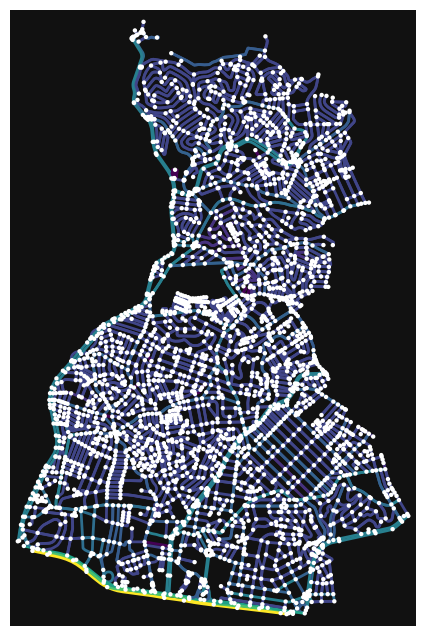

In [7]:
# Dados da subprefeitura
indice_sp = 0
nome_sp = gdf_sp_filtrado.iloc[indice_sp]['sp_nome']

# Verifica e define o CRS
if gdf_sp_filtrado.crs is None:
    gdf_sp_filtrado.set_crs(epsg=4326, inplace=True)  # Define como WGS 84 (latitude/longitude)

# Extrai a geometria
poligono = gdf_sp_filtrado.iloc[indice_sp].geometry

# Certifique-se de que o pol√≠gono est√° em EPSG:4326 (necess√°rio para OSMNX)
if gdf_sp_filtrado.crs.to_epsg() != 4326:
    poligono = gdf_sp_filtrado.to_crs(epsg=4326).iloc[indice_sp].geometry

# Obt√©m o grafo
G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)  # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reproje√ß√£o foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

if verbose:
    print("Grafo obtido com sucesso!")
    print('Sub-prefeitura selecionada: ',nome_sp)
    # Obtendo os comprimentos das arestas
    velocidades = [data['speed_kph'] for _, _, data in G_baseline.edges(data=True)]

    # Normalizando para um mapa de cores
    norm = mcolors.Normalize(vmin=min(velocidades), vmax=max(velocidades))
    cmap = cm.viridis  # Escolha um mapa de cores

    # Definir cores baseadas na velocidade
    edge_colors = [cmap(norm(l)) for l in velocidades]

    # Plotando com cores personalizadas
    fig, ax = ox.plot_graph(
        G_baseline, 
        edge_color=edge_colors, 
        node_size=10, 
        edge_linewidth=2
    )


#### Recortes dos raster em fun√ß√£o dos boundary boxes

In [ ]:
# Somente executar este trecho uma √∫nica vez
# Carregar o GeoDataFrame das subprefeituras
gdf_sp = gdf_sp_filtrado

# Listar pacotes v√°lidos
pacotes = [p for p in os.listdir(output_folder) if p.startswith("Pacote_") and p[-2:].isdigit()]

print(f"{len(pacotes)} pacotes identificados. Iniciando processamento...\n")

# Processamento
for pacote in tqdm(pacotes, desc="Processando Pacotes"):
    pacote_path = os.path.join(output_folder, pacote)
    simulacao_path = os.path.join(pacote_path, "Simula√ß√£o")
    subprefeituras_path = os.path.join(pacote_path, "Sub-prefeituras")
    
    # Criar diret√≥rio de Subprefeituras se n√£o existir
    os.makedirs(subprefeituras_path, exist_ok=True)
    
    # Filtrar subprefeituras dentro do pacote
    for _, subpref in tqdm(gdf_sp.iterrows(), total=len(gdf_sp), desc=f"Subprefeituras ({pacote})", leave=False):
        sp_nome = subpref["sp_nome"]
        sp_path = os.path.join(subprefeituras_path, sp_nome)
        os.makedirs(sp_path, exist_ok=True)
        
        # Verificar exist√™ncia da pasta simula√ß√£o
        if not os.path.exists(simulacao_path):
            print(f"[AVISO] Pasta 'simula√ß√£o' n√£o encontrada em {pacote}. Pulando...")
            continue
        
        # Processar arquivos .tif
        tif_files = [f for f in os.listdir(simulacao_path) if f.endswith(".tif") and not f.startswith("._")]
        for filename in tqdm(tif_files, desc=f"Clipando ({sp_nome})", leave=False):
            src_path = os.path.join(simulacao_path, filename)
            
            try:
                with rasterio.open(src_path) as src:
                    if gdf_sp.crs != src.crs:
                        gdf_sp = gdf_sp.to_crs(src.crs)
                    
                    sp_geometry = [subpref.geometry]
                    raster_bounds = box(*src.bounds)
                    if not raster_bounds.intersects(subpref.geometry):
                        print(f"[INFO] {filename} n√£o sobrep√µe {sp_nome}. Pulando...")
                        continue
                    
                    out_image, out_transform = mask(src, sp_geometry, crop=True)
                    out_meta = src.meta.copy()
                    out_meta.update({
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform,
                        "crs": src.crs
                    })
                    
                    output_filename = f"{os.path.splitext(filename)[0]}_{sp_nome}.tif"
                    output_path = os.path.join(sp_path, output_filename)
                    with rasterio.open(output_path, "w", **out_meta) as dest:
                        dest.write(out_image)
                    
                    #print(f"[SUCESSO] Arquivo clipado salvo: {output_path}")
            except Exception as e:
                print(f"[ERRO] Falha ao processar {filename}: {e}")

print("\nProcessamento conclu√≠do para todos os pacotes e subprefeituras!")

#### Aproximar os pares OD da rede OSMnx

Carregando dados...
Processando subprefeitura: CASA VERDE-CACHOEIRINHA


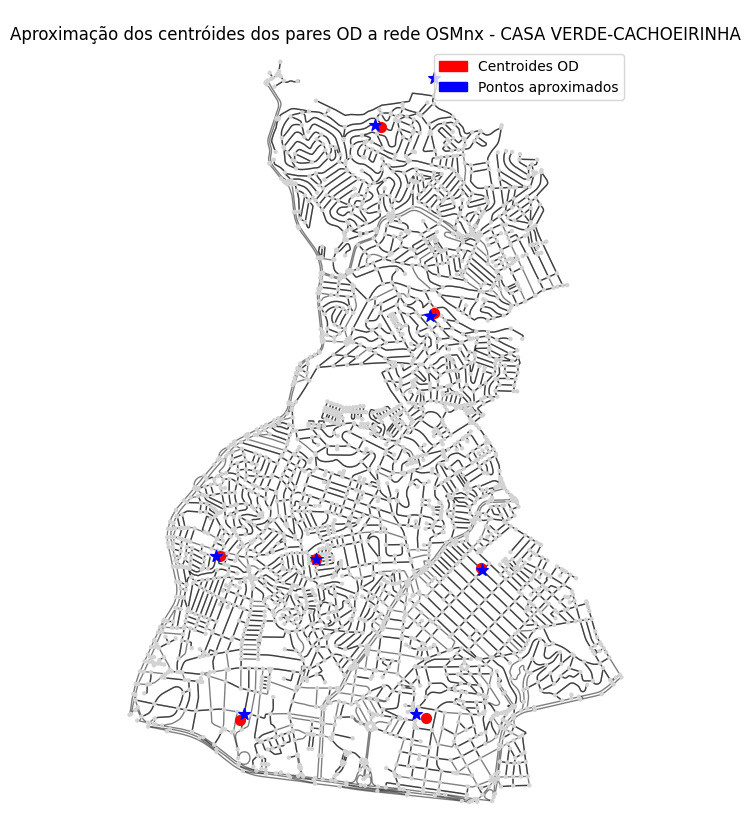

Processamento conclu√≠do!


In [8]:
# Defini√ß√£o do CRS UTM para S√£o Paulo
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S

# Ler os dados
print("Carregando dados...")
gdf_OD = gpd.read_file(zonas_shp_OD_2023).to_crs(utm_crs)
gdf_OD_SP = gdf_OD[gdf_OD['NomeMunici'] == 'S√£o Paulo'].copy()
gdf_sp_filtrado = gdf_sp_filtrado.to_crs(utm_crs)

# Iterar sobre cada subprefeitura (aqui, limitado √† primeira para teste)
resultados = {}
for idx, subprefeitura in gdf_sp_filtrado.iloc[:1].iterrows():
    nome_subprefeitura = subprefeitura["sp_nome"]
    print(f"Processando subprefeitura: {nome_subprefeitura}")
    
    # Criar GeoDataFrame da subprefeitura (em UTM)
    gdf_subpref_utm = gpd.GeoDataFrame(geometry=[subprefeitura["geometry"]], crs=utm_crs)
    
    # Converter para EPSG:4326 para extrair a rede com OSMnx (se necess√°rio)
    if gdf_subpref_utm.crs.to_epsg() != 4326:
        gdf_subpref_4326 = gdf_subpref_utm.to_crs(epsg=4326)
        poligono = gdf_subpref_4326.iloc[0].geometry
    else:
        poligono = subprefeitura["geometry"]

    # Extrair o grafo para a √°rea do pol√≠gono e adicionar velocidades (km/h)
    G_baseline = ox.graph_from_polygon(poligono, network_type="drive")
    G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)
    
    # Projetar o grafo para UTM
    G_baseline_utm = ox.project_graph(G_baseline, to_crs=utm_crs)
    
    # Cria um GeoDataFrame com os centr√≥ides dos pontos OD
    gdf_OD_centroids = gdf_OD_SP.copy()
    gdf_OD_centroids["centroide"] = gdf_OD_centroids.geometry.centroid
    # Importante: definir o CRS como o utm_crs, pois os dados j√° foram convertidos
    gdf_OD_centroids = gpd.GeoDataFrame(gdf_OD_centroids, geometry="centroide", crs=utm_crs)
    
    # Define o pol√≠gono da subprefeitura para a jun√ß√£o espacial
    subpref_polygon = gdf_subpref_utm

    # Realiza a jun√ß√£o espacial para identificar os centr√≥ides dentro da subprefeitura
    gdf_centroids_in_subpref = gdf_OD_centroids.sjoin(subpref_polygon, how="inner", predicate="within")
    
    # Agora, usamos os centr√≥ides que ca√≠ram dentro da subprefeitura
    centroides_df = gdf_centroids_in_subpref.copy()
    
    # Aproximar os pontos √† rede: encontrar o n√≥ mais pr√≥ximo para cada centroide
    coluna_nome = f"nearest_node_{nome_subprefeitura.replace(' ', '_')}"
    centroides_df[coluna_nome] = centroides_df.geometry.apply(
        lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
    )
    
    # Obter coordenadas dos n√≥s aproximados
    centroides_df["node_x"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["x"])
    centroides_df["node_y"] = centroides_df[coluna_nome].map(lambda node: G_baseline_utm.nodes[node]["y"])
    
    # Criar GeoDataFrame com os n√≥s aproximados
    gdf_nos_aproximados = gpd.GeoDataFrame(
        centroides_df,
        geometry=gpd.points_from_xy(centroides_df["node_x"], centroides_df["node_y"]),
        crs=utm_crs
    )
    
    # Armazenar resultado
    resultados[nome_subprefeitura] = gdf_nos_aproximados
    
    # Plotar: grafo, centr√≥ides originais e n√≥s aproximados
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax j√° criado
    fig, ax = ox.plot_graph(
        G_baseline_utm, ax=ax, node_color='lightgray', node_size=10,
        edge_color='black', edge_alpha=0.5, show=False, close=False
    )

    # Plota os centr√≥ides dos pontos OD (apenas os que est√£o dentro da subprefeitura)
    centroides_df.plot(ax=ax, marker='o', color='red', markersize=50, label='Centroides OD', zorder=3)

    # Plota os pontos aproximados (n√≥s da rede)
    gdf_nos_aproximados.plot(
        ax=ax, marker='*', color='blue', markersize=75,
        label='Pontos aproximados', zorder=4
    )
    
    plt.title(f'Aproxima√ß√£o dos centr√≥ides dos pares OD a rede OSMnx - {nome_subprefeitura}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Cria legendas
    legenda_centroides = mpatches.Patch(color='red', label='Centroides OD')
    legenda_aprox = mpatches.Patch(color='blue', label='Pontos aproximados')
    plt.legend(handles=[legenda_centroides, legenda_aprox])
    
    plt.show()

# Combinar todos os GeoDataFrames em um √∫nico
resultado_final = gpd.GeoDataFrame(pd.concat(resultados.values(), ignore_index=True))

print("Processamento conclu√≠do!")


#### Fun√ß√µes de apoio

In [9]:
def filtrar_centroides_por_subprefeitura(gdf_zonas, gdf_subprefeituras, subprefeitura, utm_crs):
    """
    Filtra os centroides das zonas OD que est√£o dentro de uma determinada subprefeitura.

    Par√¢metros:
    - gdf_zonas: GeoDataFrame das zonas OD
    - gdf_subprefeituras: GeoDataFrame das subprefeituras, contendo a coluna 'sp_nome'
    - subprefeitura: Nome da subprefeitura a ser filtrada
    - utm_crs: Sistema de refer√™ncia de coordenadas UTM a ser usado

    Retorna:
    - Um GeoDataFrame contendo os centroides filtrados
    """

    # Atribuir o esquema de proje√ß√£o
    gdf_zonas_utm = gdf_zonas.to_crs(utm_crs)

    # Filtrar para o munic√≠pio de S√£o Paulo
    gdf_zonas_sp = gdf_zonas_utm[gdf_zonas_utm['NomeMunici'] == 'S√£o Paulo'].copy()

    # Criar a coluna de centroides
    gdf_zonas_sp["centroid"] = gdf_zonas_sp["geometry"].centroid

    # Garantir que ambos os GeoDataFrames t√™m o mesmo CRS
    gdf_zonas_sp = gdf_zonas_sp.to_crs(gdf_subprefeituras.crs)

    # Criar um GeoDataFrame com os centroides
    centroids_gdf = gpd.GeoDataFrame(gdf_zonas_sp[['centroid']], geometry='centroid', crs=gdf_subprefeituras.crs)

    # Realizar o spatial join para adicionar a subprefeitura a cada centr√≥ide
    centroids_filtrados = gpd.sjoin(centroids_gdf, gdf_subprefeituras[['geometry', 'sp_nome']], how='inner', predicate='within')

    # Filtrar para a subprefeitura espec√≠fica
    centroids_filtrados = centroids_filtrados[centroids_filtrados['sp_nome'] == subprefeitura]

    return centroids_filtrados

In [10]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extra√≠da de um raster.

    Par√¢metros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informa√ß√µes de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transforma√ß√£o do raster para coordenadas espaciais.
        threshold (float): Profundidade m√≠nima para ajustar a velocidade.
        threshold_max (float): Profundidade m√°xima que torna a via intransit√°vel.
        speed_column (str): Nome da coluna de refer√™ncia para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em √≠ndices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo d√™ errado na transforma√ß√£o, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os √≠ndices est√£o dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extra√ß√£o do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extra√≠do do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar m√°ximo, torna-se instransit√°vel
        return 0
    elif flood_depth > threshold:
        # Aplicar a f√≥rmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que n√£o ultrapasse a velocidade original
        
    # Caso contr√°rio, manter a velocidade original
    return row[speed_column]

In [11]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Fun√ß√£o para obter o n√∫mero de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = gdf_nos_aproximados.loc[gdf_nos_aproximados[referencia] == node2, 'NumeroZona'].values[0]
    #print(f'O n√∫mero de viagens entre {zone1} e {zone2} √© {od_matrix.loc[zone1, zone2]}')
    return od_matrix.loc[zone1, zone2]

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o n√∫mero total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo m√©dio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo m√©dio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

#### Produzir novas refer√™ncias de velocidade

In [13]:
pacote_num = 'Pacote_01'

# Construir o caminho completo do diret√≥rio onde est√£o os arquivos TIFF
clipado_path = os.path.join(output_folder, pacote_num, 'Sub-prefeituras', nome_sp)

# Verificar se o diret√≥rio existe antes de continuar
if not os.path.isdir(clipado_path):
    raise FileNotFoundError(f"O diret√≥rio {clipado_path} n√£o foi encontrado.")

# Obter a lista de arquivos TIFF no diret√≥rio
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif") and not f.startswith("._")]

# Total de arquivos a serem processados
total_arquivos = len(arquivos_tif)

# Fun√ß√£o para extrair o n√∫mero que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o n√∫mero ap√≥s "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um n√∫mero grande se n√£o encontrar nada

# Ordenar a lista com base no n√∫mero extra√≠do
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)

pct1_h_2692800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2696400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2700000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2703600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2707200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2710800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2714400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2718000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2721600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2725200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2728800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2732400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2736000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2739600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2743200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2746800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2750400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2754000_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2757600_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2761200_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2764800_CASA VERDE-CACHOEIRINHA.tif
pct1_h_max_2768400_CASA VERDE-CACHOEIRINHA.tif
pct1_h_2768400_CASA VERDE-CACHOEIRINHA.tif


In [14]:
# Verificar que as colunas n√£o est√£o presentes no GDF. 
# Particularmente, verificar se a coluna speed_kph foi adicionada.
# Ela ser√° a refer√™ncia de velocidade
edges_baseline_reprojected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 7874 entries, (np.int64(25783581), np.int64(2387001370), np.int64(0)) to (np.int64(12595592440), np.int64(12595592438), np.int64(0))
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      7874 non-null   object  
 1   highway    7874 non-null   object  
 2   lanes      1774 non-null   object  
 3   maxspeed   1285 non-null   object  
 4   oneway     7874 non-null   bool    
 5   reversed   7874 non-null   object  
 6   length     7874 non-null   float64 
 7   geometry   7874 non-null   geometry
 8   speed_kph  7874 non-null   float64 
 9   name       7520 non-null   object  
 10  ref        10 non-null     object  
 11  junction   44 non-null     object  
 12  access     58 non-null     object  
 13  width      26 non-null     object  
 14  bridge     15 non-null     object  
dtypes: bool(1), float64(2), geometry(1), object(11)
memory usage: 1.1+ MB


In [15]:
# Iterar sobre os arquivos clipados
for index, filename in enumerate(arquivos_ordenados, start=1):  # Come√ßa em 1
    print(f"\nProcessando arquivo {index} de {total_arquivos}: {filename}")

    # Extrair informa√ß√µes do nome do arquivo
    match = re.search(r'pct(?P<pct>\d+)_h(?:_max)?_(?P<value>\d+)', filename)
    if match:
        pct = match.group('pct')  # Valor ap√≥s "pct"
        value = match.group('value')  # Valor num√©rico
        is_max = '_max' in filename  # Verificar se "max" est√° presente

        # Criar o nome da coluna dinamicamente
        column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
        column_name = column_suffix  # Exemplo: "pct1_h_2692800" ou "pct1_h_max_2768400"
        #print(f"Coluna gerada: {column_name}")

        # Caminho completo do arquivo raster
        raster_path = os.path.join(clipado_path, filename)

        # Abrir o raster e extrair os dados
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Ler a primeira banda do raster
            raster_transform = src.transform

        # Aplicar a fun√ß√£o de ajuste e criar uma nova coluna
        edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
            adjust_speed_batch,
            axis=1,
            args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
        )

        #vel_ajustada = edges_baseline_reprojected.copy()
        # Cria uma coluna com a diferen√ßa entre a velocidade original e a ajustada
        #vel_ajustada['speed_diff'] = vel_ajustada['speed_kph'] - vel_ajustada[column_name]

        # Estat√≠sticas descritivas da velocidade ajustada
        #print("Estat√≠sticas da velocidade ajustada:")
        #print(edges_baseline_reprojected[column_name].describe())

        # Estat√≠sticas descritivas da diferen√ßa (quanto a velocidade foi reduzida)
        #print("\nEstat√≠sticas da diferen√ßa de velocidade:")
        #print(vel_ajustada[column_name].describe())

        # N√∫mero de segmentos que tiveram a velocidade modificada
        #num_modificados = (vel_ajustada['speed_diff'] != 0).sum()
        #total_segmentos = len(vel_ajustada)
        #print(f"\nSegmentos com velocidade alterada: {num_modificados} de {total_segmentos}")
        #print(f"Percentual de segmentos alterados: {num_modificados/total_segmentos*100:.2f}%")

        # Quantas velocidades foram ajustadas para zero
        count_zero = (edges_baseline_reprojected[column_name] == 0).sum()

        # Quantas velocidades foram modificadas (diferentes da original e n√£o zero)
        count_modified = ((edges_baseline_reprojected[column_name] != edges_baseline_reprojected["speed_kph"]) & (edges_baseline_reprojected[column_name] != 0)).sum()

        # Quantas velocidades permaneceram iguais √† original
        count_unchanged = (edges_baseline_reprojected[column_name] == edges_baseline_reprojected["speed_kph"]).sum()

        print(f"Velocidades ajustadas para zero: {count_zero} ou {count_zero/len(edges_baseline_reprojected)*100:.2f}%")
        print(f"Velocidades modificadas:{count_modified} ou {count_modified/len(edges_baseline_reprojected)*100:.2f}%")
        print(f"Velocidades inalteradas: {count_unchanged} ou {count_unchanged/len(edges_baseline_reprojected)*100:.2f}%")

print("\nProcessamento conclu√≠do!\n")


Processando arquivo 1 de 23: pct1_h_2692800_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 0 ou 0.00%
Velocidades modificadas:0 ou 0.00%
Velocidades inalteradas: 7874 ou 100.00%

Processando arquivo 2 de 23: pct1_h_2696400_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 3 ou 0.04%
Velocidades modificadas:1 ou 0.01%
Velocidades inalteradas: 7870 ou 99.95%

Processando arquivo 3 de 23: pct1_h_2700000_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 56 ou 0.71%
Velocidades modificadas:6 ou 0.08%
Velocidades inalteradas: 7812 ou 99.21%

Processando arquivo 4 de 23: pct1_h_2703600_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 120 ou 1.52%
Velocidades modificadas:48 ou 0.61%
Velocidades inalteradas: 7706 ou 97.87%

Processando arquivo 5 de 23: pct1_h_2707200_CASA VERDE-CACHOEIRINHA.tif
Velocidades ajustadas para zero: 312 ou 3.96%
Velocidades modificadas:114 ou 1.45%
Velocidades inalteradas: 7448 ou 94.59%

Processando arquivo 6 de 23: p

In [16]:
# Verifique se as novas colunas foram adicionadas
# Aqui estamos procurando se as colunas com as horas de simula√ß√£o foram adicionadas.
print(edges_baseline_reprojected.columns)

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'oneway', 'reversed', 'length',
       'geometry', 'speed_kph', 'name', 'ref', 'junction', 'access', 'width',
       'bridge', 'pct1_h_2692800', 'pct1_h_2696400', 'pct1_h_2700000',
       'pct1_h_2703600', 'pct1_h_2707200', 'pct1_h_2710800', 'pct1_h_2714400',
       'pct1_h_2718000', 'pct1_h_2721600', 'pct1_h_2725200', 'pct1_h_2728800',
       'pct1_h_2732400', 'pct1_h_2736000', 'pct1_h_2739600', 'pct1_h_2743200',
       'pct1_h_2746800', 'pct1_h_2750400', 'pct1_h_2754000', 'pct1_h_2757600',
       'pct1_h_2761200', 'pct1_h_2764800', 'pct1_h_2768400_max',
       'pct1_h_2768400'],
      dtype='object')


#### Calcular os tempos de viagem

In [17]:
def add_edge_travel_times_gdf2(gdf, referencia):
    import re
    import numpy as np

    # Extrair a parte relevante da refer√™ncia (at√© a segunda sequ√™ncia num√©rica)
    padrao = r'^((?:[^\d]*\d+){2}).*'
    ref_clean = re.sub(padrao, r'\1', referencia)
    
    col_speed = ref_clean
    col_tt = f'tt_{ref_clean}'
    
    print(f'O valor da refer√™ncia √©: {col_tt}')
    
    # Garantir a exist√™ncia da coluna de velocidade; se n√£o existir, criar com valor 0
    if col_speed not in gdf.columns:
        print(f'Aviso: a coluna "{col_speed}" n√£o existe no GeoDataFrame. Criando-a com valor 0.')
        gdf[col_speed] = 0

    # Garantir que a coluna 'length' exista e preencher valores ausentes com 0
    if 'length' not in gdf.columns:
        print('Aviso: a coluna "length" n√£o existe no GeoDataFrame. Criando-a com valor 0.')
        gdf['length'] = 0
    else:
        gdf['length'] = gdf['length'].fillna(0)

    # Calcular os tempos de viagem:
    # Se a velocidade √© 0, atribuir infinito; caso contr√°rio, calcular (length * 3.6) / velocidade.
    gdf[col_tt] = np.where(gdf[col_speed] == 0, np.inf, (gdf['length'] * 3.6) / gdf[col_speed])
    
    return gdf


In [18]:
# Aplicando a fun√ß√£o para adicionar o tempo de viagem
data_batch = []
data = 0

for column_name in arquivos_ordenados:
    edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, column_name)
    data_batch.append({
                    'index': data + 1,
                    'Refer√™ncia': column_name.replace('.tif', ''), # Remove "_clp.tif" da refer√™ncia.
                })
    data += 1

edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, 'speed_kph') # Essa linha √© necess√°ria para construir o baseline no arquivo GDF
data_batch.append({
    'index': data,
    'Refer√™ncia': 'speed_kph',
})

# Criar DataFrame com os resultados
detalhes_arquivo_df = pd.DataFrame(data_batch)

# Criando a coluna "Max" com valor 0 por padr√£o
detalhes_arquivo_df["Max"] = 0

# Encontrar a linha que cont√©m "max_"
linha_max = detalhes_arquivo_df[detalhes_arquivo_df["Refer√™ncia"].str.contains("max_", na=False)]

if not linha_max.empty:
    # Extrair o n√∫mero ap√≥s "max_"
    match = re.search(r"max_(\d+)", linha_max["Refer√™ncia"].values[0])
    
    if match:
        numero_max = match.group(1)  # Captura apenas o n√∫mero ap√≥s "max_"
        
        # Atualizar a linha correspondente ao n√∫mero extra√≠do, definindo "Max" como 1
        detalhes_arquivo_df.loc[detalhes_arquivo_df["Refer√™ncia"].str.contains(f"h_{numero_max}", na=False), "Max"] = 1

# Remover a linha que cont√©m "max_"
detalhes_arquivo_df = detalhes_arquivo_df[~detalhes_arquivo_df["Refer√™ncia"].str.contains("max_", na=False)]

# Resetar o √≠ndice para manter organizado
detalhes_arquivo_df.reset_index(drop=True, inplace=True)

O valor da refer√™ncia √©: tt_pct1_h_2692800
O valor da refer√™ncia √©: tt_pct1_h_2696400
O valor da refer√™ncia √©: tt_pct1_h_2700000
O valor da refer√™ncia √©: tt_pct1_h_2703600
O valor da refer√™ncia √©: tt_pct1_h_2707200
O valor da refer√™ncia √©: tt_pct1_h_2710800
O valor da refer√™ncia √©: tt_pct1_h_2714400
O valor da refer√™ncia √©: tt_pct1_h_2718000
O valor da refer√™ncia √©: tt_pct1_h_2721600
O valor da refer√™ncia √©: tt_pct1_h_2725200
O valor da refer√™ncia √©: tt_pct1_h_2728800
O valor da refer√™ncia √©: tt_pct1_h_2732400
O valor da refer√™ncia √©: tt_pct1_h_2736000
O valor da refer√™ncia √©: tt_pct1_h_2739600
O valor da refer√™ncia √©: tt_pct1_h_2743200
O valor da refer√™ncia √©: tt_pct1_h_2746800
O valor da refer√™ncia √©: tt_pct1_h_2750400
O valor da refer√™ncia √©: tt_pct1_h_2754000
O valor da refer√™ncia √©: tt_pct1_h_2757600
O valor da refer√™ncia √©: tt_pct1_h_2761200
O valor da refer√™ncia √©: tt_pct1_h_2764800
O valor da refer√™ncia √©: tt_pct1_h_max_2768400
Aviso:

In [19]:
cols_interesse = [col for col in edges_baseline_reprojected.columns if col.startswith('tt')] + ['speed_kph']
# Substitui valores infinitos (positivos e negativos) por NaN
df_temp = edges_baseline_reprojected[cols_interesse].replace([np.inf, -np.inf], np.nan)
stats = df_temp.describe()
print(stats)

       tt_pct1_h_2692800  tt_pct1_h_2696400  tt_pct1_h_2700000  \
count        7874.000000        7871.000000        7818.000000   
mean            8.965726           8.969106           9.047224   
std             7.292306           7.302454           9.049325   
min             0.143217           0.143217           0.143217   
25%             4.012732           4.012166           4.012732   
50%             6.969162           6.969162           6.940216   
75%            11.864830          11.864830          11.851585   
max           116.909532         116.909532         373.147892   

       tt_pct1_h_2703600  tt_pct1_h_2707200  tt_pct1_h_2710800  \
count        7754.000000        7562.000000        7211.000000   
mean            9.011948           9.432839           9.449123   
std             7.540053          11.785647           8.901701   
min             0.143217           0.143217           0.143217   
25%             4.023658           4.064025           4.174256   
50%      

In [20]:
corr_matrix = edges_baseline_reprojected[cols_interesse].corr()
print(corr_matrix)


                       tt_pct1_h_2692800  tt_pct1_h_2696400  \
tt_pct1_h_2692800               1.000000           0.999310   
tt_pct1_h_2696400               0.999310           1.000000   
tt_pct1_h_2700000               0.814478           0.814478   
tt_pct1_h_2703600               0.967740           0.967740   
tt_pct1_h_2707200               0.652900           0.652900   
tt_pct1_h_2710800               0.830796           0.830796   
tt_pct1_h_2714400               0.726862           0.726862   
tt_pct1_h_2718000               0.697608           0.697608   
tt_pct1_h_2721600               0.797460           0.797460   
tt_pct1_h_2725200               0.759815           0.759815   
tt_pct1_h_2728800               0.733884           0.733884   
tt_pct1_h_2732400               0.574323           0.574323   
tt_pct1_h_2736000               0.560252           0.560252   
tt_pct1_h_2739600               0.507963           0.507963   
tt_pct1_h_2743200               0.597675           0.59

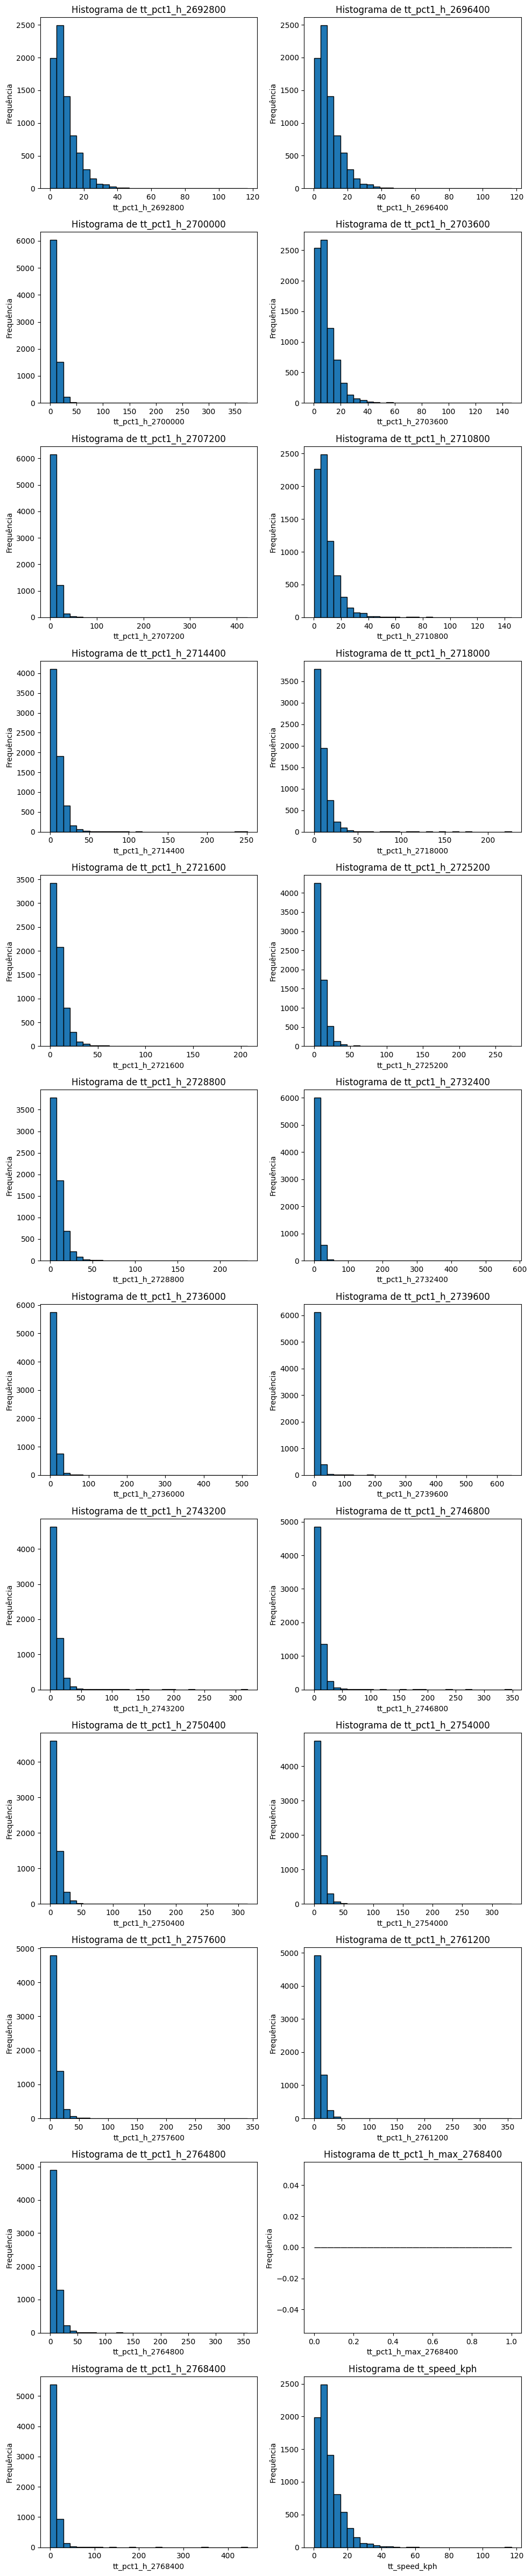

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Seleciona as colunas que come√ßam com "tt" e a coluna "tt_speed_kph"
cols_interesse = [col for col in edges_baseline_reprojected.columns if col.startswith('tt')]

# Define o n√∫mero de subplots; organizamos em 2 colunas
n_total = len(cols_interesse)
n_cols = 2
n_rows = math.ceil(n_total / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))

# Se houver apenas um subplot, encapsule-o em uma lista para facilitar a itera√ß√£o
if n_total == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Itera sobre as colunas e plota os histogramas
for i, col in enumerate(cols_interesse):
    # Remove os NaN e os valores infinitos para o histograma
    data = edges_baseline_reprojected[col].dropna()
    data = data[np.isfinite(data)]
    
    axes[i].hist(data, bins=30, edgecolor='black')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequ√™ncia')

# Remove os eixos n√£o utilizados, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [22]:
# Verifique se as novas colunas foram adicionadas.
# Aqui estamos interessados em verificar se as colunas tt (Travel Time) foram
# adicionadas ao GDF
print(edges_baseline_reprojected.columns)

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'oneway', 'reversed', 'length',
       'geometry', 'speed_kph', 'name', 'ref', 'junction', 'access', 'width',
       'bridge', 'pct1_h_2692800', 'pct1_h_2696400', 'pct1_h_2700000',
       'pct1_h_2703600', 'pct1_h_2707200', 'pct1_h_2710800', 'pct1_h_2714400',
       'pct1_h_2718000', 'pct1_h_2721600', 'pct1_h_2725200', 'pct1_h_2728800',
       'pct1_h_2732400', 'pct1_h_2736000', 'pct1_h_2739600', 'pct1_h_2743200',
       'pct1_h_2746800', 'pct1_h_2750400', 'pct1_h_2754000', 'pct1_h_2757600',
       'pct1_h_2761200', 'pct1_h_2764800', 'pct1_h_2768400_max',
       'pct1_h_2768400', 'tt_pct1_h_2692800', 'tt_pct1_h_2696400',
       'tt_pct1_h_2700000', 'tt_pct1_h_2703600', 'tt_pct1_h_2707200',
       'tt_pct1_h_2710800', 'tt_pct1_h_2714400', 'tt_pct1_h_2718000',
       'tt_pct1_h_2721600', 'tt_pct1_h_2725200', 'tt_pct1_h_2728800',
       'tt_pct1_h_2732400', 'tt_pct1_h_2736000', 'tt_pct1_h_2739600',
       'tt_pct1_h_2743200', 'tt_pct1_h_2746

#### Construir um novo grafo, com todas refer√™ncias de velocidades

In [23]:
# Conta quantas vezes 99999 aparece na coluna identificada
num_99999 = (edges_baseline_reprojected['tt_pct1_h_2757600'] == np.inf).sum()

print(f"N√∫mero de ocorr√™ncias de infinito na coluna tt_pct1_h_2757600': {num_99999}")


N√∫mero de ocorr√™ncias de infinito na coluna tt_pct1_h_2757600': 1294


MultiDiGraph with 3136 nodes and 7874 edges


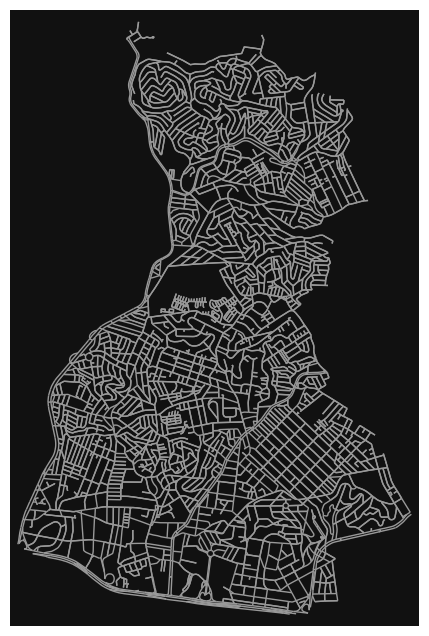

O sistema de refer√™ncia de coordenadas do G_dinamico √©: EPSG:31983


In [24]:
# Gerar o grafo e armazen√°-lo no dicion√°rio
G_dinamico = ox.graph_from_gdfs(node_baseline, edges_simulados)

# Exibir o grafo
print(G_dinamico)
ox.plot_graph(G_dinamico)

# Verificar o sistema de refer√™ncia de coordenadas
crs = G_dinamico.graph['crs']
print(f'O sistema de refer√™ncia de coordenadas do G_dinamico √©:', crs)

In [25]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'pct1_h_max_2768400',
 'ref',
 'reversed',
 'speed_kph',
 'tt_pct1_h_2692800',
 'tt_pct1_h_2696400',
 'tt_pct1_h_2700000',
 'tt_pct1_h_2703600',
 'tt_pct1_h_2707200',
 'tt_pct1_h_2710800',
 'tt_pct1_h_2714400',
 'tt_pct1_h_2718000',
 'tt_pct1_h_2721600',
 'tt_pct1_h_2725200',
 'tt_pct1_h_2728800',
 'tt_pct1_h_2732400',
 'tt_pct1_h_2736000',
 'tt_pct1_h_2739600',
 'tt_pct1_h_2743200',
 'tt_pct1_h_2746800',
 'tt_pct1_h_2750400',
 't

In [191]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math
import os
import re
from datetime import datetime, timedelta

# üïí Fun√ß√£o auxiliar para convers√£o
def que_dia_e_que_hora(segundos_desde_meia_noite_2023):
    origem = datetime(2023, 1, 1, 0, 0, 0)
    momento = origem + timedelta(seconds=segundos_desde_meia_noite_2023)
    return momento.strftime('%H:%M - %d/%m/%Y')

# üìä Fun√ß√£o principal de plotagem
def plot_series_temporal_gdf_com_baseline(
    gdf, 
    col_prefix='pct_', 
    baseline_col='pct_ref', 
    cmap_name='inferno', 
    vmin=None, 
    vmax=None,
    salvar=False,
    salvar_em_pdf=False,
    pasta_saida='.',
    titulo=f'Varia√ß√£o temporal por trecho, subprefeitura: {nome_sp}',
    verbose=True
):
    """
    Plota mapas para colunas com prefixo dado, come√ßando pela coluna de baseline,
    convertendo o n√∫mero no final do nome da coluna para hor√°rio leg√≠vel.
    """

    if baseline_col not in gdf.columns:
        raise ValueError(f"A coluna de baseline '{baseline_col}' n√£o existe no GeoDataFrame.")

    # üîé Seleciona colunas com prefixo e exclui baseline e colunas com 'max'
    colunas_temporais = [
        col for col in gdf.columns
        if col.startswith(col_prefix) and
           col != baseline_col and
           'max' not in col.lower()
    ]
    colunas_para_plotar = [baseline_col] + sorted(colunas_temporais)

    if verbose:
        print(f'üìå Colunas a serem plotadas: {colunas_para_plotar}')

    # üå°Ô∏è Escala global autom√°tica se n√£o for passada
    if vmin is None or vmax is None:
        todos_valores = pd.concat([gdf[col] for col in colunas_para_plotar])
        vmin = todos_valores.min() if vmin is None else vmin
        vmax = todos_valores.max() if vmax is None else vmax
        if verbose:
            print(f'üìä Escala autom√°tica: vmin={vmin:.2f}, vmax={vmax:.2f}')

    # üé® Colormap
    cmap = plt.colormaps.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # üìê Layout
    n_total = len(colunas_para_plotar)
    n_cols = 2
    n_rows = math.ceil(n_total / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(colunas_para_plotar):
        ax = axes[i]
        gdf.plot(
            column=col,
            cmap=cmap,
            norm=norm,
            linewidth=1.0,
            ax=ax,
            legend=True,
            legend_kwds={'label': f'{col} (%)', 'shrink': 0.6}
        )

        # üïí Extrair n√∫mero do nome da coluna e converter em HH:MM - DD/MM/AAAA
        match = re.search(r'(\d+)$', col)
        if match:
            try:
                segundos = int(match.group(1))
                titulo_formatado = que_dia_e_que_hora(segundos)
            except Exception:
                titulo_formatado = col
        else:
            titulo_formatado = col

        ax.set_title(titulo_formatado, fontsize=14)
        ax.axis('off')

    # üßπ Esconde subplots extras
    for j in range(len(colunas_para_plotar), len(axes)):
        axes[j].axis('off')

    # üì¶ Ajustes de layout e exporta√ß√£o
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(titulo, fontsize=16)

    if salvar_em_pdf:
        from matplotlib.backends.backend_pdf import PdfPages
        os.makedirs(pasta_saida, exist_ok=True)
        pdf_path = os.path.join(pasta_saida, f"{titulo.replace(' ', '_')}.pdf")
        with PdfPages(pdf_path) as pdf:
            pdf.savefig(fig)
        if verbose:
            print(f"‚úÖ PDF salvo em: {pdf_path}")
        plt.close()

    elif salvar:
        os.makedirs(pasta_saida, exist_ok=True)
        for i, col in enumerate(colunas_para_plotar):
            fig_ind, ax_ind = plt.subplots(figsize=(10, 8))
            gdf.plot(
                column=col,
                cmap=cmap,
                norm=norm,
                linewidth=1.0,
                ax=ax_ind,
                legend=True,
                legend_kwds={'label': f'{col} (%)', 'shrink': 0.6}
            )

            # T√≠tulo formatado
            match = re.search(r'(\d+)$', col)
            if match:
                try:
                    segundos = int(match.group(1))
                    titulo_formatado = que_dia_e_que_hora(segundos)
                except Exception:
                    titulo_formatado = col
            else:
                titulo_formatado = col

            ax_ind.set_title(titulo_formatado, fontsize=14)
            ax_ind.axis('off')
            path = os.path.join(pasta_saida, f"{col}.png")
            fig_ind.savefig(path, dpi=300, bbox_inches='tight')
            plt.close(fig_ind)
        if verbose:
            print(f"‚úÖ PNGs salvos em: {pasta_saida}")
    else:
        plt.show()


In [192]:
plot_series_temporal_gdf_com_baseline(
    gdf=edges_baseline_reprojected,
    col_prefix='pct',
    baseline_col='speed_kph',
    salvar_em_pdf=True,
    pasta_saida='outputs/mapas',
    vmin=0,
    vmax=90,
    verbose=False
)


In [ ]:
ox.save_graphml(G_dinamico, filepath='G_dinamico.graphml')

In [27]:
# Inicializa coluna_alvo para evitar NameError
coluna_alvo = None

# Percorre todas as arestas do grafo para encontrar um atributo que contenha "h_max"
for u, v, data in G_dinamico.edges(data=True):
    for atributo in data.keys():
        if "h_max" in atributo:
            coluna_alvo = atributo
            break  # Para ao encontrar a primeira ocorr√™ncia
    if coluna_alvo is not None:
        break

if coluna_alvo is None:
    raise ValueError("Nenhum atributo contendo 'h_max' foi encontrado nas arestas.")

# Obter todas as arestas com seus atributos (convertendo para array, se desejar)
dados_arestas = np.array([data.get(coluna_alvo, np.nan) for _, _, data in G_dinamico.edges(data=True)])

# Contar quantos valores s√£o iguais a 99999
num_99999 = np.sum(dados_arestas == np.inf)
print(f"N√∫mero de valores infinito em '{coluna_alvo}': {num_99999}")

# Contar o n√∫mero total de arestas
total_arestas = G_dinamico.number_of_edges()
print(f"N√∫mero total de arestas: {total_arestas}")


N√∫mero de valores infinito em 'pct1_h_max_2768400': 0
N√∫mero total de arestas: 7874


#### C√°lculo do caminho m√≠nimo

In [28]:
def pre_processar_grafo_star(G, referencia):
    """
    Pr√©-processa o grafo removendo arestas inv√°lidas e identificando componentes conectados.
    """
    G_filtrado = G.copy()
    
    print("N√∫mero de arestas antes do pr√©-processamento:", len(G_filtrado.edges()))
   
    edges_remover = [(u, v, k) for u, v, k, d in G_filtrado.edges(keys=True, data=True) if referencia in d and d[referencia] == float('inf')]

    G_filtrado.remove_edges_from(edges_remover)
    
    # Manter apenas a componente fortemente conectada maior
    componentes = list(nx.strongly_connected_components(G_filtrado))
    maior_componente = max(componentes, key=len)
    G_filtrado = G_filtrado.subgraph(maior_componente).copy()
    
    # Plotargrafo
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plota o grafo OSMnx no ax j√° criado
    #fig, ax = ox.plot_graph(
    #    G_filtrado, ax=ax, node_color='lightgray', node_size=10,
    #    edge_color='black', edge_alpha=0.5, show=False, close=False
    #)
    print("N√∫mero de arestas ap√≥s pr√©-processamento:", len(G_filtrado.edges()))

    return G_filtrado

def heuristica_haversine(G, origem, destino):
    """
    Calcula a dist√¢ncia haversine entre dois n√≥s do grafo.
    """
    lat1, lon1 = G.nodes[origem]['y'], G.nodes[origem]['x']
    lat2, lon2 = G.nodes[destino]['y'], G.nodes[destino]['x']
    return great_circle((lat1, lon1), (lat2, lon2)).meters

def caminho_minimo_star(G, origem, destino, peso):
    """
    Calcula o caminho m√≠nimo entre dois n√≥s no grafo pr√©-processado usando A*.
    """
    if not nx.has_path(G, origem, destino):
        return None, None
    
    try:
        caminho = nx.astar_path(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        distancia = nx.astar_path_length(G, source=origem, target=destino, weight=peso, heuristic=lambda u, v: heuristica_haversine(G, u, v))
        return caminho, distancia
    except nx.NetworkXNoPath:
        return None, None

def calcula_caminho_minimo_star(gdf_OD, referencia_OD, G, referencia, sem_caminho=None):
    """
    Calcula caminhos m√≠nimos entre pares de n√≥s em um grafo OSMnx, considerando apenas vias transit√°veis.
    """
    if sem_caminho is None:
        sem_caminho = set()
    
    G = pre_processar_grafo_star(G, referencia)  # Pr√©-processar grafo antes das buscas
    peso = referencia if any(referencia in d for _, _, d in G.edges(data=True)) else "length"
    
    nos_validos = set(G.nodes)  # Reduz buscas no grafo
    data_batch = []
    tempo_acumulado = 0 # Acumulador para o c√°lculo do tempo m√©dio
    total_viagens = 0 # Contador de viagens
    start_time = time.time()
    
    for node1, node2 in itertools.combinations(gdf_OD[referencia_OD], 2):
        if node1 == node2 or (node1, node2) in sem_caminho or node1 not in nos_validos or node2 not in nos_validos:
            continue

        num_viagens = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
        if num_viagens == 0:
            continue # Se n√£o h√° viagens registradas, n√£o processa
            
        caminho, tempo = caminho_minimo_star(G, node1, node2, peso)
        if caminho is not None:
            tempo_total = tempo * num_viagens  # Multiplica pelo n√∫mero de viagens
            tempo_acumulado += tempo_total  # Acumula o tempo total
            total_viagens += num_viagens  # Acumula o n√∫mero total de viagens
            
            data_batch.append({
                'Refer√™ncia': referencia,
                'Origem': node1,
                'Destino': node2,
                'Tempo de viagem (min)': tempo / 60,
                'N√∫mero de viagens': num_viagens,
                'Tempo total ponderado (min)': tempo_total / 60,
                'N√∫mero de n√≥s': len(caminho),
                'Percurso entre n√≥s': list(caminho)
            })
        else:
            sem_caminho.add((node1, node2))

    tempo_medio = (tempo_acumulado / total_viagens) / 60 if total_viagens > 0 else None
    
    print(f"Tempo de processamento: {(time.time() - start_time) / 60:.2f} min")
    print(f'Viagens calculadas: {len(data_batch)}')
    print(f'Viagens sem conex√£o: {len(sem_caminho)}')
    print(f'Tempo m√©dio de viagem ponderado: {tempo_medio:.2f} min' if tempo_medio else "Nenhuma viagem processada")
    
    return pd.DataFrame(data_batch), sem_caminho, tempo_medio


In [29]:
# Atualiza√ß√µes para incorporar o sem_caminho e otimiza√ß√µes de c√≥digo
import time
import itertools
import pandas as pd

def calcula_caminho_minimo_star2(gdf_OD, referencia_OD, G, referencia, **kwargs):
    """
    Calcula caminhos m√≠nimos entre pares de n√≥s em um grafo OSMnx, considerando apenas vias transit√°veis.
    Otimizado para rodar em grande escala.
    """
    sem_caminho = kwargs.get('sem_caminho_chuva', None)
    if sem_caminho is None:
        sem_caminho = set()
        #print(f'{blue}Sem_caminho veio vazio! {reset}')
    else:
        # Se for inteiro, transforme em conjunto vazio
        #print(f'{blue}Opa! Sem_caminho veio com alguma coisa! {reset} {len(sem_caminho)}')
        if not isinstance(sem_caminho, (list, set, tuple)):
            sem_caminho = set()

        sem_caminho = set(tuple(pair) for pair in sem_caminho)  # Garante que a estrutura √© um conjunto de tuplas

    G = pre_processar_grafo_star(G, referencia)  # Pr√©-processa o grafo
    peso = referencia if any(referencia in d for _, _, d in G.edges(data=True)) else "length"
    print(f'A refer√™ncia utilizada √©: ',referencia)
    print(f'A refer√™ncia OD utilizada √©: ',referencia_OD)

    nos_validos = set(G.nodes)  # Evita buscas repetitivas no grafo
    #print(f'N√≥s validos: ',nos_validos)
    data_batch = []
    tempo_acumulado = 0
    total_viagens = 0
    start_time = time.time()

    # Pr√©-calcula n√∫mero de viagens entre pares
    matriz_od = { (n1, n2): get_number_of_trips(n1, n2, referencia_OD, matriz_od_25) 
                  for n1, n2 in itertools.permutations(gdf_OD[referencia_OD], 2) 
                  if (n1, n2) not in sem_caminho and n1 in nos_validos and n2 in nos_validos }
    #print(f'A matriz OD √©: ',matriz_od)

    for (node1, node2), num_viagens in matriz_od.items():
        #print('Come√ßando os c√°lculos dos tempos de viagem')
        if num_viagens == 0:
            continue  # Ignora pares sem viagens registradas
        
        caminho, tempo = caminho_minimo_star(G, node1, node2, peso)
        if caminho is not None:
            tempo_total = tempo * num_viagens
            tempo_acumulado += tempo_total
            total_viagens += num_viagens

            data_batch.append({
                'Refer√™ncia': referencia,
                'Origem': node1,
                'Destino': node2,
                'Tempo de viagem (min)': tempo / 60,
                'N√∫mero de viagens': num_viagens,
                'Tempo total ponderado (min)': tempo_total / 60,
                'N√∫mero de n√≥s': len(caminho),
                'Percurso entre n√≥s': list(caminho)
            })
        else:
            print(f'Sem caminho antes: {sem_caminho}')
            sem_caminho.add((node1, node2))
            print(f'Sem caminho depois: {sem_caminho}')

    tempo_medio = (tempo_acumulado / total_viagens) / 60 if total_viagens > 0 else None

    print(f"Tempo de processamento: {(time.time() - start_time) / 60:.2f} min")
    print(f'Viagens calculadas: {len(data_batch)}')
    print(f'Viagens sem conex√£o: {blue}{len(sem_caminho)}{reset}')
    print(f'Tempo m√©dio de viagem ponderado: {blue} {tempo_medio:.2f} min {reset}' if tempo_medio else "Nenhuma viagem processada")

    return pd.DataFrame(data_batch), sem_caminho, tempo_medio


In [30]:
atributos_tt = set()
    
for _, _, dados in G_dinamico.edges(data=True):
    for atributo in dados.keys():
        if atributo.startswith("tt"):
            atributos_tt.add(atributo)

atributos_tt = [linha for linha in atributos_tt if "speed"not in linha]

#Ordenar a lista pelo n√∫mero extra√≠do
atributos_tt_ord = sorted(atributos_tt, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in atributos_tt_ord:
    print(arquivo)

# Limitando o tamanho da lista para facilitar o debug
#atributos_tt_ord = atributos_tt_ord[6:7]
print(atributos_tt_ord)

tt_pct1_h_2692800
tt_pct1_h_2696400
tt_pct1_h_2700000
tt_pct1_h_2703600
tt_pct1_h_2707200
tt_pct1_h_2710800
tt_pct1_h_2714400
tt_pct1_h_2718000
tt_pct1_h_2721600
tt_pct1_h_2725200
tt_pct1_h_2728800
tt_pct1_h_2732400
tt_pct1_h_2736000
tt_pct1_h_2739600
tt_pct1_h_2743200
tt_pct1_h_2746800
tt_pct1_h_2750400
tt_pct1_h_2754000
tt_pct1_h_2757600
tt_pct1_h_2761200
tt_pct1_h_2764800
tt_pct1_h_2768400
tt_pct1_h_max_2768400
['tt_pct1_h_2692800', 'tt_pct1_h_2696400', 'tt_pct1_h_2700000', 'tt_pct1_h_2703600', 'tt_pct1_h_2707200', 'tt_pct1_h_2710800', 'tt_pct1_h_2714400', 'tt_pct1_h_2718000', 'tt_pct1_h_2721600', 'tt_pct1_h_2725200', 'tt_pct1_h_2728800', 'tt_pct1_h_2732400', 'tt_pct1_h_2736000', 'tt_pct1_h_2739600', 'tt_pct1_h_2743200', 'tt_pct1_h_2746800', 'tt_pct1_h_2750400', 'tt_pct1_h_2754000', 'tt_pct1_h_2757600', 'tt_pct1_h_2761200', 'tt_pct1_h_2764800', 'tt_pct1_h_2768400', 'tt_pct1_h_max_2768400']


In [31]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'pct1_h_max_2768400',
 'ref',
 'reversed',
 'speed_kph',
 'tt_pct1_h_2692800',
 'tt_pct1_h_2696400',
 'tt_pct1_h_2700000',
 'tt_pct1_h_2703600',
 'tt_pct1_h_2707200',
 'tt_pct1_h_2710800',
 'tt_pct1_h_2714400',
 'tt_pct1_h_2718000',
 'tt_pct1_h_2721600',
 'tt_pct1_h_2725200',
 'tt_pct1_h_2728800',
 'tt_pct1_h_2732400',
 'tt_pct1_h_2736000',
 'tt_pct1_h_2739600',
 'tt_pct1_h_2743200',
 'tt_pct1_h_2746800',
 'tt_pct1_h_2750400',
 't

In [32]:
# Fun√ß√£o auxiliar para calcular tempos de viagem
def calcular_tempo_viagem(gdf, referencia, coluna_peso, grafo, sem_caminho_chuva=None):
    # Prepara os par√¢metros extras para a fun√ß√£o auxiliar, se necess√°rio
    extra_params = {}
    if sem_caminho_chuva is not None:
        extra_params['sem_caminho_chuva'] = sem_caminho_chuva

    inicio = time.time()
    tempos, sem_caminho, tempo_medio = calcula_caminho_minimo_star2(gdf, referencia, grafo, coluna_peso, **extra_params)
    tempo_execucao = time.time() - inicio

    #print(f'{blue}Tamanho de sem_caminho: {len(sem_caminho)}{reset}')
    
    return tempo_medio, sem_caminho, len(sem_caminho), tempo_execucao

In [34]:
# Se no c√≥digo original voc√™ usou replace(' ', '_'), fa√ßa o mesmo aqui:
subpref_underscored = nome_sp.replace(' ', '_')

# Supondo que o padr√£o seja "nearest_node_" + subpref_underscored
coluna_desejada = f"nearest_node_{subpref_underscored}"

print("Coluna constru√≠da dinamicamente:", coluna_desejada)

# Verifique se essa coluna existe no seu GDF:
if coluna_desejada in gdf_nos_aproximados.columns:
    print(f"A coluna '{coluna_desejada}' existe!\n")
else:
    print(f"A coluna '{coluna_desejada}' n√£o foi encontrada no GDF.\n")

# Verifica se coluna faz parte dos atributos das arestas de G_dinamico
for u, v, data in G_dinamico.edges(data=True):
    if coluna not in data:
        print(f"Aresta {u} - {v} N√ÉO possui o atributo ", coluna)

Coluna constru√≠da dinamicamente: nearest_node_CASA_VERDE-CACHOEIRINHA
A coluna 'nearest_node_CASA_VERDE-CACHOEIRINHA' existe!



NameError: name 'coluna' is not defined

In [90]:
# Inicializa a lista de resultados
resultados = []

# Loop sobre os atributos
for coluna in tqdm(atributos_tt_ord, desc="Processando atributos", unit='atributo'):
    print(f'\nIniciando o c√°lculo para a refer√™ncia: {coluna}')
      
    # 1. C√°lculo com chuva
    print(f'Calculando tempo de viagem {blue} COM CHUVA...{reset}')
    print('Nearest node baseline: ',coluna_desejada)
    print('Refer√™ncia: ',coluna)
    tt_chuva, sem_caminho_chuva, viagens_ignoradas_chuva, tempo_execucao_chuva = calcular_tempo_viagem(
    gdf_nos_aproximados, coluna_desejada, coluna, G_dinamico
    )

    # 2. C√°lculo sem chuva, modificado
    print(f'Calculando tempo de viagem {blue} SEM CHUVA, MODIFICADO...{reset}')
    tt_seco_mod, _, viagens_ignoradas_mod, tempo_execucao_mod = calcular_tempo_viagem(
    gdf_nos_aproximados, coluna_desejada, 'tt_speed_kph', G_dinamico, sem_caminho_chuva
    )

    # Adiciona os resultados √† lista
    resultados.append({
        'coluna': coluna,
        'tt_chuva': tt_chuva,
        'tt_seco_mod': tt_seco_mod,
        'viagens_ignoradas_chuva': viagens_ignoradas_chuva,
        'viagens_ignoradas_mod': viagens_ignoradas_mod,
        'tempo_execucao_chuva': tempo_execucao_chuva,
        'tempo_execucao_mod': tempo_execucao_mod
    })

# Converte os resultados para um DataFrame
df_resultados_resiliencia = pd.DataFrame(resultados)

Processando atributos:   0%|          | 0/23 [00:00<?, ?atributo/s]


Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2692800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2692800
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_pct1_h_2692800
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA


Processando atributos:   4%|‚ñç         | 1/23 [00:00<00:21,  1.02atributo/s]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2696400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2696400
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7815
A refer√™ncia utilizada √©:  tt_pct1_h_2696400
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:   9%|‚ñä         | 2/23 [00:02<00:21,  1.01s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2700000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2700000
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7731
A refer√™ncia utilizada √©:  tt_pct1_h_2700000
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  13%|‚ñà‚ñé        | 3/23 [00:03<00:24,  1.25s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2703600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2703600
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7614
A refer√™ncia utilizada √©:  tt_pct1_h_2703600
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.08 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  17%|‚ñà‚ñã        | 4/23 [00:04<00:21,  1.13s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2707200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2707200
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7471
A refer√™ncia utilizada √©:  tt_pct1_h_2707200
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.10 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utiliz

Processando atributos:  22%|‚ñà‚ñà‚ñè       | 5/23 [00:06<00:23,  1.31s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2710800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2710800
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7048
A refer√™ncia utilizada √©:  tt_pct1_h_2710800
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.57 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA


Processando atributos:  26%|‚ñà‚ñà‚ñå       | 6/23 [00:06<00:19,  1.16s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2714400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2714400
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6799
A refer√™ncia utilizada √©:  tt_pct1_h_2714400
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.21 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  30%|‚ñà‚ñà‚ñà       | 7/23 [00:07<00:16,  1.06s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2718000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2718000
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6729
A refer√™ncia utilizada √©:  tt_pct1_h_2718000
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.71 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  35%|‚ñà‚ñà‚ñà‚ñç      | 8/23 [00:09<00:18,  1.22s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2721600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2721600
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6669
A refer√™ncia utilizada √©:  tt_pct1_h_2721600
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.80 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  39%|‚ñà‚ñà‚ñà‚ñâ      | 9/23 [00:10<00:15,  1.11s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2725200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2725200
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6651
A refer√™ncia utilizada √©:  tt_pct1_h_2725200
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.86 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utiliz

Processando atributos:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 10/23 [00:11<00:15,  1.22s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2728800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2728800
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6622
A refer√™ncia utilizada √©:  tt_pct1_h_2728800
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.92 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA


Processando atributos:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 11/23 [00:12<00:13,  1.12s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2732400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2732400
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6581
A refer√™ncia utilizada √©:  tt_pct1_h_2732400
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.18 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 12/23 [00:14<00:13,  1.21s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2736000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2736000
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6556
A refer√™ncia utilizada √©:  tt_pct1_h_2736000
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.37 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 13/23 [00:15<00:11,  1.14s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2739600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2739600
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6533
A refer√™ncia utilizada √©:  tt_pct1_h_2739600
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.69 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 14/23 [00:15<00:09,  1.06s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2743200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2743200
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6521
A refer√™ncia utilizada √©:  tt_pct1_h_2743200
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.46 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 15/23 [00:17<00:09,  1.19s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2746800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2746800
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6517
A refer√™ncia utilizada √©:  tt_pct1_h_2746800
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.32 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 16/23 [00:18<00:07,  1.10s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2750400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2750400
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6503
A refer√™ncia utilizada √©:  tt_pct1_h_2750400
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.34 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 17/23 [00:19<00:07,  1.22s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2754000
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2754000
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6504
A refer√™ncia utilizada √©:  tt_pct1_h_2754000
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.20 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 18/23 [00:20<00:05,  1.13s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2757600
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2757600
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6514
A refer√™ncia utilizada √©:  tt_pct1_h_2757600
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.12 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 19/23 [00:21<00:04,  1.08s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2761200
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2761200
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6498
A refer√™ncia utilizada √©:  tt_pct1_h_2761200
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.05 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 20/23 [00:23<00:03,  1.21s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2764800
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2764800
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6468
A refer√™ncia utilizada √©:  tt_pct1_h_2764800
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.57 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874


Processando atributos:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 21/23 [00:24<00:02,  1.12s/atributo]

N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_2768400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_2768400
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 6459
A refer√™ncia utilizada √©:  tt_pct1_h_2768400
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.01 min
Viagens calculadas: 21
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  7.74 min 
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utiliz

Processando atributos:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 22/23 [00:25<00:01,  1.29s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 

Iniciando o c√°lculo para a refer√™ncia: tt_pct1_h_max_2768400
Calculando tempo de viagem  COM CHUVA...
Nearest node baseline:  nearest_node_CASA_VERDE-CACHOEIRINHA
Refer√™ncia:  tt_pct1_h_max_2768400
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 0
A refer√™ncia utilizada √©:  tt_pct1_h_max_2768400
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA
Tempo de processamento: 0.00 min
Viagens calculadas: 0
Viagens sem conex√£o: 0
Nenhuma viagem processada
Calculando tempo de viagem  SEM CHUVA, MODIFICADO...
N√∫mero de arestas antes do pr√©-processamento: 7874
N√∫mero de arestas ap√≥s pr√©-processamento: 7817
A refer√™ncia utilizada √©:  tt_speed_kph
A refer√™ncia OD utilizada √©:  nearest_node_CASA_VERDE-CACHOEIRINHA


Processando atributos: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 23/23 [00:26<00:00,  1.15s/atributo]

Tempo de processamento: 0.00 min
Viagens calculadas: 27
Viagens sem conex√£o: 0
Tempo m√©dio de viagem ponderado:  6.06 min 


#### Montar o histograma

In [94]:
df_resultados_resiliencia

# Remover a linha que cont√©m "max" na coluna 'Hora Simulada'
resiliencia_df = df_resultados_resiliencia[~df_resultados_resiliencia['coluna'].str.contains('max', na=False)]

# Extrair o n√∫mero ap√≥s "h_" e converter para inteiro para ordena√ß√£o
#resiliencia_df['h_value'] = resiliencia_df['Hora Simulada'].str.extract(r'h_(\d+)').astype(float)

# Ordenar o DataFrame pelo valor num√©rico extra√≠do
resiliencia_df = resiliencia_df.sort_values(by='coluna', ascending=True)

# Resetar o √≠ndice ap√≥s a ordena√ß√£o
resiliencia_df = resiliencia_df.reset_index(drop=True)

# Exibir o DataFrame transformado
print(resiliencia_df)

               coluna  tt_chuva  tt_seco_mod  viagens_ignoradas_chuva  \
0   tt_pct1_h_2692800  6.057428     6.057428                        0   
1   tt_pct1_h_2696400  6.057428     6.057428                        0   
2   tt_pct1_h_2700000  6.058123     6.057428                        0   
3   tt_pct1_h_2703600  6.082914     6.057428                        0   
4   tt_pct1_h_2707200  6.101860     6.057428                        0   
5   tt_pct1_h_2710800  6.565227     6.057428                        0   
6   tt_pct1_h_2714400  7.207434     6.057428                        0   
7   tt_pct1_h_2718000  6.707774     6.057428                        0   
8   tt_pct1_h_2721600  6.804957     6.057428                        0   
9   tt_pct1_h_2725200  6.856419     6.057428                        0   
10  tt_pct1_h_2728800  6.924393     6.057428                        0   
11  tt_pct1_h_2732400  7.179607     6.057428                        0   
12  tt_pct1_h_2736000  7.367485     6.057428       

In [95]:
resiliencia_df

coluna  tt_chuva  tt_seco_mod  viagens_ignoradas_chuva  \
0   tt_pct1_h_2692800  6.057428     6.057428                        0   
1   tt_pct1_h_2696400  6.057428     6.057428                        0   
2   tt_pct1_h_2700000  6.058123     6.057428                        0   
3   tt_pct1_h_2703600  6.082914     6.057428                        0   
4   tt_pct1_h_2707200  6.101860     6.057428                        0   
5   tt_pct1_h_2710800  6.565227     6.057428                        0   
6   tt_pct1_h_2714400  7.207434     6.057428                        0   
7   tt_pct1_h_2718000  6.707774     6.057428                        0   
8   tt_pct1_h_2721600  6.804957     6.057428                        0   
9   tt_pct1_h_2725200  6.856419     6.057428                        0   
10  tt_pct1_h_2728800  6.924393     6.057428                        0   
11  tt_pct1_h_2732400  7.179607     6.057428                        0   
12  tt_pct1_h_2736000  7.367485     6.057428                        0   
13  tt_pct1_h_2739600  7.690824     6.057428                        0   
14  tt_pct1_h_2743200  7.458676     6.057428                        0   
15  tt_pct1_h_2746800  7.323729     6.057428                        0   
16  tt_pct1_h_2750400  7.335986     6.057428                        0   
17  tt_pct1_h_2754000  7.204690     6.057428                        0   
18  tt_pct1_h_2757600  7.117856     6.057428                        0   
19  tt_pct1_h_2761200  7.050580     6.057428                        0   
20  tt_pct1_h_2764800  7.569510     6.057428                        0   
21  tt_pct1_h_2768400  7.742423     6.057428                        0   

    viagens_ignoradas_mod  tempo_execucao_chuva  tempo_execucao_mod  
0                       0              0.522508            0.461219  
1                       0              0.460185            0.570147  
2                       0              1.077937            0.445104  
3                       0              0.473660            0.466204  
4                       0              0.530046            1.119251  
5                       0              0.406509            0.456826  
6                       0              0.400678            0.453102  
7                       0              1.110757            0.451101  
8                       0              0.405193            0.456281  
9                       0              0.403905            1.066460  
10                      0              0.443023            0.449949  
11                      0              0.409879            1.011989  
12                      0              0.502605            0.467827  
13                      0              0.419268            0.445081  
14                      0              1.058847            0.453675  
15                      0              0.428294            0.460746  
16                      0              0.403844            1.084577  
17                      0              0.430959            0.482523  
18                      0              0.529861            0.452713  
19                      0              1.034431            0.468622  
20                      0              0.447548            0.447492  
21                      0              0.623759            1.082074

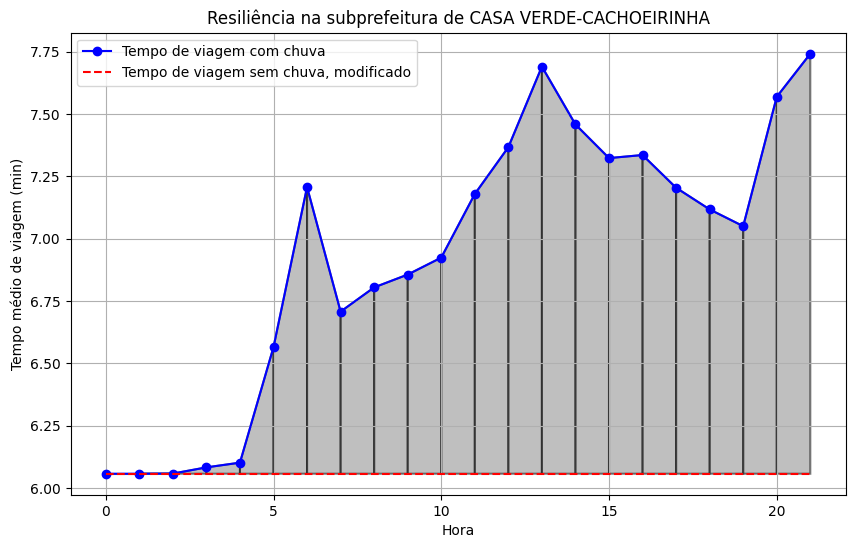

A resili√™ncia (√°rea total sob a curva): 18.36 


In [37]:
# Definir baseline como 'TT sem chuva, modificado'
baseline = resiliencia_df['tt_seco_mod'].min()
area_total = 0

# Criar figura
plt.figure(figsize=(10, 6))

# Criar √≠ndices para plotagem
x = np.arange(len(resiliencia_df))
y = resiliencia_df['tt_chuva'].values
baseline_values = resiliencia_df['tt_seco_mod'].values

# Plotar linha de TT com chuva
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Tempo de viagem com chuva')

# Adicionar linha de baseline
plt.plot(x, baseline_values, linestyle='--', color='r', label='Tempo de viagem sem chuva, modificado')

# Preencher trap√©zios entre baseline e TT com chuva
for i in range(len(x) - 1):
    x_trapezoid = [x[i], x[i], x[i+1], x[i+1]]
    y_trapezoid = [baseline_values[i], y[i], y[i+1], baseline_values[i]]

    # Preencher o trap√©zio
    plt.fill(x_trapezoid, y_trapezoid, 'gray', alpha=0.5, edgecolor='k', linewidth=1.5)

    # Calcular a √°rea do trap√©zio
    base1 = abs(y[i] - baseline_values[i])
    base2 = abs(y[i+1] - baseline_values[i+1])
    altura = 1  # Como o eixo X √© discreto, altura = 1 unidade
    area_trap = 0.5 * (base1 + base2) * altura
    area_total += area_trap

# Ajustes do gr√°fico
plt.xlabel('Hora')
plt.ylabel('Tempo m√©dio de viagem (min)')
plt.title('Resili√™ncia na subprefeitura de ' + nome_sp)
plt.legend()
plt.grid(True)

# Exibir gr√°fico
plt.show()

# Exibir √°rea total sob a curva
print(f"A resili√™ncia (√°rea total sob a curva): {area_total:.2f} ")

#### Obten√ß√£o da informa√ß√£o de chuva

In [38]:
#arquivo_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estacÃßoÃÉes_meteoroloÃÅgicas/meteorologicas_2023/dados_cge___P400_Riacho_Grande.csv'

diret√≥rio_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estacÃßoÃÉes_meteoroloÃÅgicas/meteorologicas_2023'

In [39]:
# Indicador num√©rico dos postos:
postos = [503, 1000866, 495, 1000840, 1000854, 1000850, 1000852, 634, 592, 846, 507, 1000300, 1000860, 1000887, 1000859, 524, 1000864, 1000844, 1000862, 1000882, 1000635, 1000842, 1000848, 504, 515, 509, 1000944, 540, 510, 400, 1000876]

# Dados fornecidos (reutilizados):
names = [
    "S√© - CGE (PMSP/SE-01)", "S√© - Anhembi (PMSP/SE-02)", "Vila Mariana (PMSP/VM-01)", 
    "Ipiranga (PMSP/IP-01)", "Campo Limpo (PMSP/CL-03)", "M Boi Mirim (PMSP/MB-01)", 
    "Santo Amaro (PMSP/SA-01)", "Jabaquara (PMSP/JA-01)", "Cidade Ademar - (PMSP/AD-01) / S√£o Paulo", 
    "Capela do Socorro (PMSP/CS-01)", "Parelheiros - Barragem (PMSP/PA-01)", 
    "Esta√ß√£o Meteorol√≥gica Marsilac", "Mooca (PMSP/MO-01)", "Penha - Rinc√£o (PMSP/PE-01)", 
    "Aricanduva - Vila Formosa (PMSP/AF-02)", "Vila Prudente - (PMSP/VP-01)", "Itaquera (PMSP/IQ-02)", 
    "S√£o Mateus (PMSP/SM-05)", "S√£o Miguel Paulista (PMSP/MP-01)", "Itaim Paulista (PMSP/IT-01)", 
    "Pinheiros (PMSP/PI-01)", "Butant√£ (PMSP/BT-02)", "Lapa (PMSP/LA-01)", "Perus (PMSP/PR-01)", 
    "Pirituba (PMSP/PJ-01)", "Freguesia do √ì (PMSP/FO-01)", "Trememb√© (PMSP/JT-01)", 
    "Vila Maria - Vila Guilherme (PMSP/MG-01)", "Santana/Tucuruvi - COMDEC (PMSP/ST-01)", 
    "Riacho Grande", "Mau√° - Pa√ßo Municipal"
]

# Exemplo de lista adicional de esta√ß√µes:
estacoes = ['0', '1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','30','31']

# √çndices
indices = list(range(len(names)))

# Criar dicion√°rio com o formato {index: {name, estacao, posto}}
dicionario_estacoes = {
    i: {'Name': names[i], 'Estacao': estacoes[i], 'Posto': postos[i]} 
    for i in indices
}

# Exibir o dicion√°rio
dicionario_estacoes

{0: {'Name': 'S√© - CGE (PMSP/SE-01)', 'Estacao': '0', 'Posto': 503},
 1: {'Name': 'S√© - Anhembi (PMSP/SE-02)', 'Estacao': '1', 'Posto': 1000866},
 2: {'Name': 'Vila Mariana (PMSP/VM-01)', 'Estacao': '2', 'Posto': 495},
 3: {'Name': 'Ipiranga (PMSP/IP-01)', 'Estacao': '3', 'Posto': 1000840},
 4: {'Name': 'Campo Limpo (PMSP/CL-03)', 'Estacao': '4', 'Posto': 1000854},
 5: {'Name': 'M Boi Mirim (PMSP/MB-01)', 'Estacao': '5', 'Posto': 1000850},
 6: {'Name': 'Santo Amaro (PMSP/SA-01)', 'Estacao': '6', 'Posto': 1000852},
 7: {'Name': 'Jabaquara (PMSP/JA-01)', 'Estacao': '7', 'Posto': 634},
 8: {'Name': 'Cidade Ademar - (PMSP/AD-01) / S√£o Paulo',
  'Estacao': '8',
  'Posto': 592},
 9: {'Name': 'Capela do Socorro (PMSP/CS-01)', 'Estacao': '9', 'Posto': 846},
 10: {'Name': 'Parelheiros - Barragem (PMSP/PA-01)',
  'Estacao': '10',
  'Posto': 507},
 11: {'Name': 'Esta√ß√£o Meteorol√≥gica Marsilac',
  'Estacao': '11',
  'Posto': 1000300},
 12: {'Name': 'Mooca (PMSP/MO-01)', 'Estacao': '12', 'Pos

In [40]:
def listar_csv_chuva(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diret√≥rio fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extens√£o .csv
        # Reparar que os dados est√£o filtrados
        if arquivo.endswith(".csv"):
            arquivos_csv.append(arquivo)
                
    return arquivos_csv
    
def buscar_estacao_por_posto(dicionario, posto_desejado):
    for info in dicionario.values():
        if info['Posto'] == posto_desejado:
            return info['Estacao']
        else:
            print(f'O posto {posto_desejado} n√£o foi encontrado')
    return "Posto n√£o encontrado"

In [41]:
import os
import pandas as pd
from glob import glob

# Fun√ß√£o para processar um √∫nico arquivo CSV
def processar_arquivo_chuva(arquivo_chuva):
    # Carregar o CSV
    df_chuva_10min = pd.read_csv(arquivo_chuva, sep=',')
    
    # Verificar se o DataFrame n√£o est√° vazio
    if df_chuva_10min.empty:
        print(f"Arquivo {arquivo_chuva} est√° vazio. Pulando.")
        return None
    
    # Selecionar as colunas relevantes
    df_chuva_10min = df_chuva_10min.loc[:, ['DATA', 'Posto', 'PLU(mm)']]
    
    # Converter os valores da coluna 'PLU(mm)' de mm/h para m/h
    #df_chuva_10min = converter_mm_para_m(df_chuva_10min, 'PLU(mm)')

    # Converter a coluna 'DATA' para datetime
    df_chuva_10min['DATA'] = pd.to_datetime(df_chuva_10min['DATA'])
    
    # Filtrar pelos meses desejados 
    meses_desejados = [1, 2, 3]  # Janeiro, Fevereiro e Mar√ßo
    df_chuva_10min = df_chuva_10min[df_chuva_10min['DATA'].dt.month.isin(meses_desejados)]
    
     # Verificar se o DataFrame ainda cont√©m dados ap√≥s o filtro
    if df_chuva_10min.empty:
        print(f"Nenhum dado relevante nos meses desejados no arquivo {arquivo_chuva}. Pulando.")
        return None
    
    # Definir a coluna 'DATA' como √≠ndice
    df_chuva_10min.set_index('DATA', inplace=True)
    
    # Somar os valores de 'PLU(mm)' a cada hora e criar um novo DataFrame com os dados agregados
    df_chuva_hora = df_chuva_10min['PLU(mm)'].resample('h').sum().to_frame()
    
    # Capturar o n√∫mero do posto (assumindo que √© o mesmo para todas as linhas)
    numero_posto = df_chuva_10min['Posto'].iloc[0]
    if numero_posto == 400:
        print('Achei um dos perdidos! ', numero_posto)
        
    # Excluir a coluna 'Posto'
    df_chuva_10min.drop(columns=['Posto'], inplace=True)
    
    # Renomear a coluna 'PLU(mm)' para incluir o n√∫mero do posto
    estacao = buscar_estacao_por_posto(dicionario_estacoes, numero_posto)
    df_chuva_hora.rename(columns={'PLU(mm)': estacao}, inplace=True)
    
    # Criar novas colunas 'Dia' e 'Hora' com base no √≠ndice
    df_chuva_hora['Dia'] = df_chuva_hora.index.date
    df_chuva_hora['Hora'] = df_chuva_hora.index.time
    
    return df_chuva_hora
    
def converter_mm_para_m(df, nome_coluna):
    # De acordo com as informa√ß√µes encontradas no tutorial do SynxFlow, os dados de chuva
    # dever√£o ser inseridos como m/h: 
    # https://synxflow.readthedocs.io/en/latest/Tutorials/flood.html
    # The other columns are the rainfall intensity values (in meter per second) for cells with rain mask indices starting from 0
    # Verificar se a coluna existe no DataFrame
    if nome_coluna in df.columns:
        # Converter os valores de mm/h para m/h
        df[nome_coluna] = df[nome_coluna] / 1000
        # N√£o tenho certeza, mas me parece ser necess√°rio dividir por 3600, passando de segundo para hora:
        df[nome_coluna] = df[nome_coluna] / 3600
    else:
        print(f"Coluna '{nome_coluna}' n√£o encontrada no DataFrame.")
    
    return df

In [42]:
# Fun√ß√£o para processar todos os arquivos CSV em um diret√≥rio
def processar_todos_arquivos_chuva(diretorio):
    # Encontrar todos os arquivos CSV no diret√≥rio
    arquivos_csv = glob(os.path.join(diretorio, '*.csv'))
    
    # Criar uma lista para armazenar os DataFrames processados
    dfs_processados = []
    
    # Iterar sobre todos os arquivos CSV
    for arquivo in arquivos_csv:
        print(f"Processando {arquivo}...")
        df_processado = processar_arquivo_chuva(arquivo)
        if df_processado is not None:
            dfs_processados.append(df_processado)
    
    # Concatenar todos os DataFrames processados (usando join para garantir alinhamento por 'DATA')
    df_final = pd.concat(dfs_processados, axis=1, join='outer')
    
    # Remover poss√≠veis duplicatas no √≠ndice
    df_final = df_final[~df_final.index.duplicated(keep='first')]
    
    # Remover colunas desnecess√°rias (mantendo apenas 'DATA' e os valores de PLU)
    colunas_a_remover = [col for col in df_final.columns if 'Dia' in col or 'Hora' in col]
    df_final = df_final.drop(columns=colunas_a_remover)
    
    # Identificar a primeira coluna como coluna de data, assumindo que seja a primeira coluna do DataFrame
    primeira_coluna = df_final.columns[0]  # Obtenha o nome da primeira coluna

    # Excluir colunas com o t√≠tulo 'Posto n√£o encontrado'
    df_final = df_final.loc[:, ~df_final.columns.str.contains('Posto n√£o encontrado')]

    # Adiciona uma coluna 1 com valores zerados
    df_final.loc[:,'1'] = 0

    # Adiciona uma coluna 29 com valores zerados, j√° que esse pluviometro est√° localizado em Santana do Parna√≠ba (fora dos limites do mun√≠cipio de S√£o Paulo)
    df_final.loc[:,'29'] = 0

    # Ordenar as colunas num√©ricas em ordem crescente
    colunas_numericas = sorted([col for col in df_final.columns if col.isnumeric()], key=int)

    # Verificar se a primeira coluna √© de datas ou texto e organizar a ordem
    if primeira_coluna not in colunas_numericas:
        # Colocar a primeira coluna (DATA) antes das colunas num√©ricas ordenadas
        df_final = df_final[[primeira_coluna] + colunas_numericas]
    else:
        # Caso contr√°rio, apenas reordena as colunas num√©ricas
        df_final = df_final[colunas_numericas]

    df_final = adicionar_indexador(df_final)
    
    # Pegando todas as colunas do DataFrame
    colunas = df_final.columns.tolist()
    
    # Movendo a coluna 'indexador' para ser a segunda
    colunas.remove('indexador')
    nova_ordem = ['indexador'] + colunas

    # Reordenando o DataFrame
    df_final = df_final[nova_ordem]

    return df_final

In [43]:
def adicionar_indexador(df):
    # Cria uma coluna 'indexador' come√ßando em 0 e incrementando 3600 a cada linha
    df['indexador'] = range(0, len(df) * 3600, 3600)
    return df

In [44]:
df_final_2023 = processar_todos_arquivos_chuva(diret√≥rio_chuva)

# Verificar as primeiras linhas do DataFrame final
df_final_2023

Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estacÃßoÃÉes_meteoroloÃÅgicas/meteorologicas_2023/dados_cge___P524_Vila_Prudente____PMSP_VP_01_.csv...
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
O posto 524 n√£o foi encontrado
Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estacÃßoÃÉes_

indexador      0  1       2      3      4      5  \
DATA                                                                    
2023-01-01 00:00:00          0  2.256  0   4.700  0.564  3.384  0.940   
2023-01-01 01:00:00       3600  1.504  0   6.768  0.000  2.256  1.692   
2023-01-01 02:00:00       7200  3.948  0   7.520  0.000  2.444  2.444   
2023-01-01 03:00:00      10800  4.136  0  10.152  0.000  2.444  3.196   
2023-01-01 04:00:00      14400  0.940  0   7.144  1.504  2.444  0.940   
...                        ...    ... ..     ...    ...    ...    ...   
2023-03-31 19:00:00    7758000  0.000  0   3.008  0.000  1.316  4.136   
2023-03-31 20:00:00    7761600  2.256  0   2.632  0.000  1.692  0.000   
2023-03-31 21:00:00    7765200  2.820  0   3.008  0.000  3.760  2.444   
2023-03-31 22:00:00    7768800  1.316  0   5.076  0.000  3.008  0.000   
2023-03-31 23:00:00    7772400  7.520  0   2.256  0.000  3.948  0.000   

                           6        7      8  ...     22     23       24  \
DATA                                          ...                          
2023-01-01 00:00:00  124.340  118.046  0.000  ...  4.512  1.692  123.665   
2023-01-01 01:00:00  122.961  116.223  0.000  ...  3.384  0.188  121.983   
2023-01-01 02:00:00  122.457  117.503  0.376  ...  1.692  0.564  123.242   
2023-01-01 03:00:00  122.235  118.328  3.008  ...  4.888  0.000  120.021   
2023-01-01 04:00:00  120.573  114.943  0.000  ...  2.068  0.000  117.039   
...                      ...      ...    ...  ...    ...    ...      ...   
2023-03-31 19:00:00  134.623  130.996  3.384  ...  5.264  5.452  134.482   
2023-03-31 20:00:00  136.850  132.982  0.000  ...  5.640  1.128  141.572   
2023-03-31 21:00:00  135.096  128.561  1.316  ...  3.384  2.444  136.527   
2023-03-31 22:00:00  131.844  125.024  0.000  ...  3.760  0.000  135.197   
2023-03-31 23:00:00  131.519  126.265  0.000  ...  2.820  0.564  133.868   

                        25   26       27      28  29     30   31  
DATA                                                              
2023-01-01 00:00:00  0.752  0.0  117.744   2.820   0  0.376  0.0  
2023-01-01 01:00:00  0.000  0.0  118.610   5.828   0  0.752  0.0  
2023-01-01 02:00:00  0.188  0.0  119.123   1.316   0  0.752  0.0  
2023-01-01 03:00:00  0.000  0.0  116.959   7.708   0  1.880  0.0  
2023-01-01 04:00:00  0.000  0.0  113.112   4.136   0  4.888  0.0  
...                    ...  ...      ...     ...  ..    ...  ...  
2023-03-31 19:00:00  0.000  0.0  122.477   3.384   0  0.752  0.0  
2023-03-31 20:00:00  0.000  0.0  125.730   9.588   0  1.316  0.0  
2023-03-31 21:00:00  0.000  0.0  124.823   9.024   0  0.000  0.0  
2023-03-31 22:00:00  0.000  0.0  122.516  11.844   0  0.564  0.0  
2023-03-31 23:00:00  0.000  0.0  121.088   6.392   0  0.000  0.0  

[2160 rows x 33 columns]

#### Alinhamento com o pacote sendo processado

In [45]:
pacotes = '/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/pacotes.simul_2023_1120.xls'

pacote_num

'Pacote_01'

In [ ]:
# Carregar o arquivo Excel
df_pacotes = pd.read_excel(pacotes)

# Exibir as primeiras linhas para entender a estrutura dos dados (opcional)
#print(df_pacotes.head())

# Usando express√£o regular para extrair apenas os n√∫meros
numero_extraido = re.search(r'\d+', pacote_num).group()

# Convertendo diretamente para float (remove zeros √† esquerda e adiciona ".0")
numero_com_ponto = float(int(numero_extraido))

# Localize a linha que corresponde ao pacote_num (supondo que h√° uma coluna chamada 'pacote_num')
linha_pacote = df_pacotes[df_pacotes['Pacote'] == numero_com_ponto]

# Verifique se a linha foi encontrada
if not linha_pacote.empty:
    # Supondo que as colunas de hora inicial e final s√£o 'hora_inicial' e 'hora_final'
    hora_inicial = linha_pacote['Simula√ß√£o In√≠cio'].values[0]
    hora_final = linha_pacote['Simula√ß√£o Final'].values[0]
    print(f'Hora inicial da simula√ß√£o: {hora_inicial}')
    print(f'Hora final da simula√ß√£o: {hora_final}')
    data_inicial = linha_pacote['Data_Simul_Ini'].values[0]
    data_final = linha_pacote['Data_Simul_Fim'].values[0]
    print(f'Data inicial da simula√ß√£o: {data_inicial}')
    print(f'Data final da simula√ß√£o: {data_final}')
else:
    print(f'Pacote n√∫mero {numero_com_ponto} n√£o encontrado no arquivo.')


  Data evento Hor√°rio Inicial Hor√°rio Final Data_Simul_Ini Data_Simul_Fim  \
0  2023-02-01        06:25:00      22:31:00     2023-02-01     2023-02-02   
1  2023-02-02        08:50:00      21:35:00     2023-02-02     2023-02-02   
2  2023-02-03        00:00:00      23:59:59     2023-02-03     2023-02-03   
3  2023-02-04        00:00:00      23:59:59     2023-02-04     2023-02-04   
4  2023-02-05        00:00:00      23:59:59     2023-02-05     2023-02-05   

  Simula√ß√£o In√≠cio Simula√ß√£o Final       Tipo     datetime_inicio  \
0         04:25:00        00:31:00  Detalhado 2023-02-01 04:25:00   
1         06:50:00        23:35:00  Detalhado 2023-02-02 06:50:00   
2         00:00:00        23:59:59    Inteiro 2023-02-03 00:00:00   
3         00:00:00        23:59:59    Inteiro 2023-02-04 00:00:00   
4         00:00:00        23:59:59    Inteiro 2023-02-05 00:00:00   

         datetime_fim  horas_simuladas  Pacote  Index In√≠cio  Index Final  \
0 2023-02-02 00:31:00             20.

In [47]:
from datetime import datetime, timedelta

# Datas base
data_inicial = datetime.fromisoformat("2023-02-01T00:00:00")
data_final = datetime.fromisoformat("2023-02-02T00:00:00")

# Horas como timedelta (certo!)
hora_inicial = timedelta(hours=4, minutes=25)   # 04:25:00
hora_final = timedelta(hours=0, minutes=31)     # 00:31:00

# Combina√ß√£o correta (datetime + timedelta)
inicio_simulacao = data_inicial + hora_inicial
fim_simulacao = data_final + hora_final

# Gerar o intervalo completo entre data + hora inicial e final
inicio_simulacao = data_inicial + hora_inicial
fim_simulacao = data_final + hora_final

# Filtrar o DataFrame com base nesse intervalo
df_filtrado = df_final_2023.loc[(df_final_2023.index >= inicio_simulacao) & (df_final_2023.index <= fim_simulacao)]

df_filtrado


indexador       0  1       2      3       4       5  \
DATA                                                                       
2023-02-01 05:00:00    2696400   0.000  0   5.076  0.000   3.196   9.212   
2023-02-01 06:00:00    2700000   0.000  0   4.888  0.000   0.000   9.776   
2023-02-01 07:00:00    2703600   0.000  0   0.940  0.000   0.940  11.092   
2023-02-01 08:00:00    2707200   4.700  0   2.068  0.000   3.572  13.160   
2023-02-01 09:00:00    2710800   4.888  0   4.136  0.000   2.444  10.904   
2023-02-01 10:00:00    2714400   9.964  0   2.632  0.000   2.256  13.536   
2023-02-01 11:00:00    2718000   8.084  0   2.820  0.000   6.768  14.476   
2023-02-01 12:00:00    2721600  10.340  0   2.820  0.000  10.340  13.536   
2023-02-01 13:00:00    2725200   8.084  0   5.452  0.000   7.332  19.176   
2023-02-01 14:00:00    2728800  12.408  0   8.272  0.000   9.400   9.776   
2023-02-01 15:00:00    2732400  10.528  0   3.948  0.000   9.776  13.724   
2023-02-01 16:00:00    2736000   9.776  0   6.768  0.000  12.408  11.280   
2023-02-01 17:00:00    2739600   9.964  0   6.768  0.000   9.964   9.212   
2023-02-01 18:00:00    2743200   5.264  0   5.076  0.000   8.836   9.588   
2023-02-01 19:00:00    2746800   2.632  0   5.640  0.000   7.332   7.144   
2023-02-01 20:00:00    2750400   2.068  0   5.452  0.000   5.828   5.076   
2023-02-01 21:00:00    2754000   2.632  0   4.136  0.000   5.076   5.264   
2023-02-01 22:00:00    2757600   4.136  0   5.452  0.752   4.700  15.228   
2023-02-01 23:00:00    2761200  10.528  0  14.664  2.068   5.264  13.160   
2023-02-02 00:00:00    2764800   8.460  0  13.160  0.000  11.280  18.612   

                           6        7      8  ...      22      23       24  \
DATA                                          ...                            
2023-02-01 05:00:00  123.978  120.756  1.316  ...   3.196   7.520  120.372   
2023-02-01 06:00:00  123.516  120.534  0.000  ...   6.392   7.708  121.208   
2023-02-01 07:00:00  123.706  120.594  1.316  ...   6.580   9.024  121.400   
2023-02-01 08:00:00  121.601  120.130  2.444  ...   6.392   4.136  120.513   
2023-02-01 09:00:00  123.071  120.534  5.828  ...   7.520   4.700  122.205   
2023-02-01 10:00:00  126.748  125.186  1.504  ...  11.844   4.700  126.283   
2023-02-01 11:00:00  129.375  129.114  2.256  ...  11.280   7.708  130.555   
2023-02-01 12:00:00  136.979  135.862  3.384  ...   9.400   9.588  143.357   
2023-02-01 13:00:00  148.845  145.349  6.016  ...  18.424   9.588  157.787   
2023-02-01 14:00:00  159.831  159.479  7.144  ...  15.980   6.204  160.314   
2023-02-01 15:00:00  159.741  158.181  7.708  ...  15.792   6.580  164.466   
2023-02-01 16:00:00  165.090  163.004  5.828  ...  11.280   8.836  169.521   
2023-02-01 17:00:00  173.066  171.020  3.384  ...  21.996   8.084  169.752   
2023-02-01 18:00:00  168.403  166.116  9.024  ...  15.792   1.880  174.808   
2023-02-01 19:00:00  166.781  165.059  5.264  ...  12.972   3.196  177.739   
2023-02-01 20:00:00  167.628  167.014  2.444  ...  13.912   1.504  176.741   
2023-02-01 21:00:00  164.053  161.674  4.888  ...   9.776   0.000  165.653   
2023-02-01 22:00:00  155.845  150.254  5.828  ...   8.272   0.000  154.071   
2023-02-01 23:00:00  139.177  136.184  1.880  ...  12.784  11.092  144.664   
2023-02-02 00:00:00  125.941  126.626  5.264  ...   9.588  12.220  138.985   

                        25     26       27      28  29      30   31  
DATA                                                                 
2023-02-01 05:00:00  0.564  0.000  115.519   3.760   0  16.544  0.0  
2023-02-01 06:00:00  4.512  1.128  113.320   0.188   0  13.160  0.0  
2023-02-01 07:00:00  0.188  1.128  112.366   5.264   0  11.844  0.0  
2023-02-01 08:00:00  1.880  0.000  113.323  11.844   0  13.160  0.0  
2023-02-01 09:00:00  4.136  0.564  115.378  13.912   0  10.340  0.0  
2023-02-01 10:00:00  1.504  0.000  120.524  10.528   0  18.048  0.0  
2023-02-01 11:00:00  3.572  0.000  126.374  10.904   0  13.160  0.0  
2

In [48]:
raster_poligono_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Rain_mask_Sao_Paulo.tif'

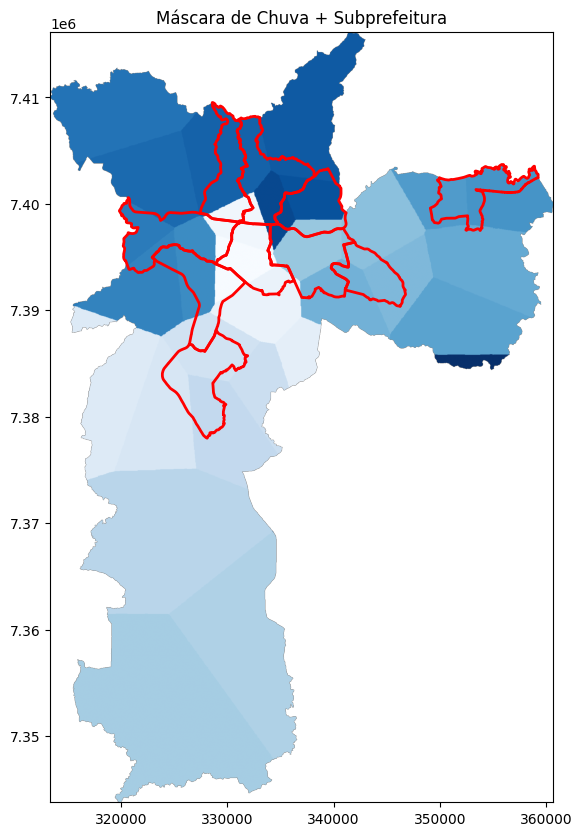

In [49]:
from rasterio.plot import show

# Abrir o raster e plotar
with rasterio.open(raster_poligono_chuva) as src:
    fig, ax = plt.subplots(figsize=(10, 10))

    # Mostrar o raster
    show(src, ax=ax, cmap='Blues')

    # Mostrar a subprefeitura (com borda e preenchimento transparente)
    gdf_sp_filtrado.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    ax.set_title('M√°scara de Chuva + Subprefeitura')
    plt.show()

In [52]:
# Lista de resultados
resultados = []

for idx, row in gdf_sp_filtrado.iterrows():
    nome_sub = row['sp_nome']  # ajuste conforme a sua coluna
    geom = [row['geometry']]

    with rasterio.open(raster_poligono_chuva) as src:
        out_image, out_transform = mask(src, geom, crop=True)
        nodata =  src.nodata
    
    dados = out_image[0]

    # M√°scara para excluir nodata
    if nodata is not None:
        dados = dados[dados != nodata]
    else:
        dados = dados[~np.isnan(dados)]

    area_total_pixels = dados.size  # total de pixels v√°lidos (n√£o √© m¬≤, √© n¬∫ de pixels)

    # Contar pixels por valor
    valores, contagens = np.unique(dados, return_counts=True)

    for val, count in zip(valores, contagens):
        percentual = (count / area_total_pixels) * 100

        resultados.append({
            'Subprefeitura': nome_sub,
            'Esta√ß√£o Meteorol√≥gica': int(val),
            'Percentual da √Årea (%)': round(percentual, 1)
        })

# Criar o DataFrame com os resultados
df_final = pd.DataFrame(resultados)

# Exibir tudo (ajust√°vel conforme a necessidade)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df_final)

                Subprefeitura  Esta√ß√£o Meteorol√≥gica  Percentual da √Årea (%)
0     CASA VERDE-CACHOEIRINHA                      1                    19.4
1     CASA VERDE-CACHOEIRINHA                     25                    80.6
2                        LAPA                      0                     5.8
3                        LAPA                      1                     9.4
4                        LAPA                     20                    28.3
5                        LAPA                     21                    12.7
6                        LAPA                     22                    35.1
7                        LAPA                     24                     8.3
8                        LAPA                     25                     0.4
9                          SE                      0                    46.1
10                         SE                      1                    27.1
11                         SE                      2                    

In [53]:
# Criar um dicion√°rio de refer√™ncia r√°pido: valor_raster -> nome esta√ß√£o
map_valor_para_nome = {
    k: v['Name'] for k, v in dicionario_estacoes.items()
}

# Agora, adicionar a coluna com o nome da esta√ß√£o no df_final
df_final['Esta√ß√£o'] = df_final['Esta√ß√£o Meteorol√≥gica'].map(map_valor_para_nome)

# Agrupar por subprefeitura e exibir os resultados
subprefeituras = df_final['Subprefeitura'].unique()

for sub in subprefeituras:
    print(f"\nSubprefeitura: {sub}")
    dados_sub = df_final[df_final['Subprefeitura'] == sub]
    
    for _, linha in dados_sub.iterrows():
        nome_estacao = linha['Esta√ß√£o']
        percentual = linha['Percentual da √Årea (%)']
        print(f" - Esta√ß√£o: {nome_estacao}, Percentual: {percentual:.1f}%")



Subprefeitura: CASA VERDE-CACHOEIRINHA
 - Esta√ß√£o: S√© - Anhembi (PMSP/SE-02), Percentual: 19.4%
 - Esta√ß√£o: Freguesia do √ì (PMSP/FO-01), Percentual: 80.6%

Subprefeitura: LAPA
 - Esta√ß√£o: S√© - CGE (PMSP/SE-01), Percentual: 5.8%
 - Esta√ß√£o: S√© - Anhembi (PMSP/SE-02), Percentual: 9.4%
 - Esta√ß√£o: Pinheiros (PMSP/PI-01), Percentual: 28.3%
 - Esta√ß√£o: Butant√£ (PMSP/BT-02), Percentual: 12.7%
 - Esta√ß√£o: Lapa (PMSP/LA-01), Percentual: 35.1%
 - Esta√ß√£o: Pirituba (PMSP/PJ-01), Percentual: 8.3%
 - Esta√ß√£o: Freguesia do √ì (PMSP/FO-01), Percentual: 0.4%

Subprefeitura: SE
 - Esta√ß√£o: S√© - CGE (PMSP/SE-01), Percentual: 46.1%
 - Esta√ß√£o: S√© - Anhembi (PMSP/SE-02), Percentual: 27.1%
 - Esta√ß√£o: Vila Mariana (PMSP/VM-01), Percentual: 24.1%
 - Esta√ß√£o: Mooca (PMSP/MO-01), Percentual: 1.5%
 - Esta√ß√£o: Santana/Tucuruvi - COMDEC (PMSP/ST-01), Percentual: 1.3%

Subprefeitura: SANTANA-TUCURUVI
 - Esta√ß√£o: S√© - Anhembi (PMSP/SE-02), Percentual: 9.5%
 - Esta√ß√£o: Freg

#### Resili√™ncia ponderada pela chuva

##### Bloco 1 - √Årea total de resili√™ncia / Chuva acumulada na subprefeitura

In [140]:
# Exemplo: df_final com 'Subprefeitura', 'Esta√ß√£o', 'Percentual da √Årea (%)'
# Exemplo: dicionario_estacoes com √≠ndice -> {'Name': ..., 'Posto': ...}
# Exemplo: chuva_total = {posto: valor}  ‚Üê chuva acumulada por esta√ß√£o
# Exemplo: nome_sp = "LAPA"

# Filtrar esta√ß√µes e percentuais da subprefeitura atual
dados_sp = df_final[df_final['Subprefeitura'] == nome_sp]

# Calcular chuva acumulada ponderada pela √°rea da subprefeitura
chuva_ponderada = 0
for _, linha in dados_sp.iterrows():
    estacao_nome = linha['Esta√ß√£o']
    percentual_area = linha['Percentual da √Årea (%)']
    
    # Encontrar posto (ID da esta√ß√£o)
    posto = None
    for k, v in dicionario_estacoes.items():
        if v['Name'] == estacao_nome:
            posto = v['Posto']
            break
    
    if posto is not None:
        chuva = df_filtrado.loc[posto, 'Chuva']
        chuva_ponderada += (chuva * percentual_area / 100)

# C√°lculo do √≠ndice
indice_exposicao_total = chuva_ponderada / area_total

print(f"Chuva acumulada ponderada: {chuva_ponderada:.2f} mm")
print(f"√çndice de exposi√ß√£o acumulado: {indice_exposicao_total:.4f} mm/min")


KeyError: 'Chuva'

In [141]:
df_filtrado

indexador       0  1       2      3       4       5  \
DATA                                                                       
2023-02-01 05:00:00    2696400   0.000  0   5.076  0.000   3.196   9.212   
2023-02-01 06:00:00    2700000   0.000  0   4.888  0.000   0.000   9.776   
2023-02-01 07:00:00    2703600   0.000  0   0.940  0.000   0.940  11.092   
2023-02-01 08:00:00    2707200   4.700  0   2.068  0.000   3.572  13.160   
2023-02-01 09:00:00    2710800   4.888  0   4.136  0.000   2.444  10.904   
2023-02-01 10:00:00    2714400   9.964  0   2.632  0.000   2.256  13.536   
2023-02-01 11:00:00    2718000   8.084  0   2.820  0.000   6.768  14.476   
2023-02-01 12:00:00    2721600  10.340  0   2.820  0.000  10.340  13.536   
2023-02-01 13:00:00    2725200   8.084  0   5.452  0.000   7.332  19.176   
2023-02-01 14:00:00    2728800  12.408  0   8.272  0.000   9.400   9.776   
2023-02-01 15:00:00    2732400  10.528  0   3.948  0.000   9.776  13.724   
2023-02-01 16:00:00    2736000   9.776  0   6.768  0.000  12.408  11.280   
2023-02-01 17:00:00    2739600   9.964  0   6.768  0.000   9.964   9.212   
2023-02-01 18:00:00    2743200   5.264  0   5.076  0.000   8.836   9.588   
2023-02-01 19:00:00    2746800   2.632  0   5.640  0.000   7.332   7.144   
2023-02-01 20:00:00    2750400   2.068  0   5.452  0.000   5.828   5.076   
2023-02-01 21:00:00    2754000   2.632  0   4.136  0.000   5.076   5.264   
2023-02-01 22:00:00    2757600   4.136  0   5.452  0.752   4.700  15.228   
2023-02-01 23:00:00    2761200  10.528  0  14.664  2.068   5.264  13.160   
2023-02-02 00:00:00    2764800   8.460  0  13.160  0.000  11.280  18.612   

                           6        7      8       9     10     11       12  \
DATA                                                                          
2023-02-01 05:00:00  123.978  120.756  1.316   0.000  0.000  0.000  122.658   
2023-02-01 06:00:00  123.516  120.534  0.000   0.000  0.000  0.000  122.729   
2023-02-01 07:00:00  123.706  120.594  1.316   0.000  0.000  0.000  123.132   
2023-02-01 08:00:00  121.601  120.130  2.444   0.000  0.000  1.692  121.932   
2023-02-01 09:00:00  123.071  120.534  5.828   0.000  0.000  2.068  122.791   
2023-02-01 10:00:00  126.748  125.186  1.504   0.000  0.000  5.264  127.695   
2023-02-01 11:00:00  129.375  129.114  2.256   0.000  0.000  8.084  133.475   
2023-02-01 12:00:00  136.979  135.862  3.384   3.384  8.648  9.024  142.226   
2023-02-01 13:00:00  148.845  145.349  6.016   4.512  8.272  6.768  155.531   
2023-02-01 14:00:00  159.831  159.479  7.144   0.000  7.896  7.144  165.442   
2023-02-01 15:00:00  159.741  158.181  7.708   9.964  7.332  9.400  165.050   
2023-02-01 16:00:00  165.090  163.004  5.828   3.008  4.888  1.128  176.308   
2023-02-01 17:00:00  173.066  171.020  3.384   9.024  1.880  1.504  171.676   
2023-02-01 18:00:00  168.403  166.116  9.024   2.820  0.752  0.752  172.845   
2023-02-01 19:00:00  166.781  165.059  5.264   6.392  1.880  0.564  173.127   
2023-02-01 20:00:00  167.628  167.014  2.444   4.512  2.256  1.504  176.783   
2023-02-01 21:00:00  164.053  161.674  4.888   3.948  4.324  1.128  169.219   
2023-02-01 22:00:00  155.845  150.254  5.828   2.068  1.504  0.000  155.945   
2023-02-01 23:00:00  139.177  136.184  1.880  10.904  0.564  0.000  132.518   
2023-02-02 00:00:00  125.941  126.626  5.264  15.228  3.572  5.640  123.777   

                         13       14      15       16      17       18  \
DATA                                                                     
2023-02-01 05:00:00   0.000  119.544   1.504  123.424   0.000  118.449   
2023-02-01 06:00:00   0.000  119.970   0.188  124.069   0.000  117.945   
2023-02-01 07:00:00   0.000  119.900   0.000  123.544   0.000  117.935   
2023-02-01 08:00:00   0.000  120.171   0.000  123.785   0.000  118.148   
2023-02-01 09:00:00   0.000  122.125   0.000  125.609   0.000  119.698   
2023-02-01 10:00:00   0.000  126.294   3.196  131.511   0.000  122.819   
2023-02-01 11:00:

##### Bloco 2 - √Årea hor√°ria de resili√™ncia / Chuva hor√°ria na subprefeitura

In [64]:
# Supondo que: 
# - nome_sp √© o nome da subprefeitura (ex: "LAPA")
# - df_final cont√©m: 'Subprefeitura', 'Esta√ß√£o', 'Valor do Raster', 'Percentual da √Årea (%)'
# - dicionario_estacoes cont√©m: {√≠ndice: {'Estacao': '0', 'Posto': ..., 'Name': ...}}
# - df_filtrado tem colunas ['0', '1', ..., '31'] com os dados de chuva por hora

indices_por_hora = []
chuva_ponderada_por_hora = []  # <- lista para armazenar os valores de chuva

# Filtra a subprefeitura atual
dados_sp = df_final[df_final['Subprefeitura'] == nome_sp]

# Criar um mapa: estacao_id ('0', '1', ...) -> percentual
percentuais_estacoes = {}
for _, linha in dados_sp.iterrows():
    estacao_nome = linha['Esta√ß√£o']
    #print(estacao_nome)
    percentual = linha['Percentual da √Årea (%)']
    #print(percentual)

    # Encontrar a estacao (√≠ndice string) correspondente no dicionario
    for idx, dados in dicionario_estacoes.items():
        if dados['Name'] == estacao_nome:
            estacao_id = dados['Estacao']  # ex: '0'
            print(estacao_id)
            percentuais_estacoes[estacao_id] = percentual
            break

# Itera pelas linhas do df_filtrado (uma por hora)
for i in range(len(df_filtrado) - 1):
    # √Årea do trap√©zio
    base1 = abs(y[i] - baseline_values[i])
    base2 = abs(y[i+1] - baseline_values[i+1])
    area_trap = 0.5 * (base1 + base2)
    
    if area_trap == 0:
        indices_por_hora.append(0.0)
        continue

    # Chuva ponderada para esta hora
    index_hora = df_filtrado.index[i]
    chuva_hora = df_filtrado.loc[index_hora]

    chuva_ponderada = 0
    for estacao_id, percentual in percentuais_estacoes.items():
        chuva_valor = chuva_hora.get(estacao_id, 0)
        chuva_ponderada += (chuva_valor * percentual / 100)

    # Armazenar chuva ponderada
    chuva_ponderada_por_hora.append(chuva_ponderada)

    # Calcular √≠ndice (prote√ß√£o contra divis√£o por zero)
    if chuva_ponderada == 0:
        indices_por_hora.append(0.0)
    else:
        indice = area_trap / chuva_ponderada
        indices_por_hora.append(indice)
    
# Exibir resultados
for i, val in enumerate(indices_por_hora):
    print(f"Hora {i}: √≠ndice de exposi√ß√£o = {val:.4f} UNIDADES")


1
25
Hora 0: √≠ndice de exposi√ß√£o = 0.0000 UNIDADES
Hora 1: √≠ndice de exposi√ß√£o = 0.0001 UNIDADES
Hora 2: √≠ndice de exposi√ß√£o = 0.0864 UNIDADES
Hora 3: √≠ndice de exposi√ß√£o = 0.0231 UNIDADES
Hora 4: √≠ndice de exposi√ß√£o = 0.0828 UNIDADES
Hora 5: √≠ndice de exposi√ß√£o = 0.6838 UNIDADES
Hora 6: √≠ndice de exposi√ß√£o = 0.3127 UNIDADES
Hora 7: √≠ndice de exposi√ß√£o = 1.1532 UNIDADES
Hora 8: √≠ndice de exposi√ß√£o = 0.3402 UNIDADES
Hora 9: √≠ndice de exposi√ß√£o = 0.2036 UNIDADES
Hora 10: √≠ndice de exposi√ß√£o = 0.4102 UNIDADES
Hora 11: √≠ndice de exposi√ß√£o = 0.2866 UNIDADES
Hora 12: √≠ndice de exposi√ß√£o = 0.9713 UNIDADES
Hora 13: √≠ndice de exposi√ß√£o = 1.1126 UNIDADES
Hora 14: √≠ndice de exposi√ß√£o = 0.8002 UNIDADES
Hora 15: √≠ndice de exposi√ß√£o = 1.6795 UNIDADES
Hora 16: √≠ndice de exposi√ß√£o = 4.0023 UNIDADES
Hora 17: √≠ndice de exposi√ß√£o = 1.4570 UNIDADES
Hora 18: √≠ndice de exposi√ß√£o = 0.2053 UNIDADES


In [76]:
len(df_filtrado)

20

In [149]:
from datetime import datetime, timedelta

def que_dia_e_que_hora(segundos, origem="2023-01-01 00:00:00"):
    """
    Converte segundos desde uma data de origem para um objeto datetime.
    
    Par√¢metros:
    - segundos (int ou float): n√∫mero de segundos desde a origem.
    - origem (str ou datetime): data e hora de in√≠cio, padr√£o "2023-01-01 00:00:00".
    
    Retorna:
    - datetime correspondente.
    """
    if isinstance(origem, str):
        origem = datetime.fromisoformat(origem)
    
    dt = origem + timedelta(seconds=segundos)

    return dt.strftime("%d/%m/%Y %H:%M")

In [150]:
from datetime import datetime, timedelta, time
import matplotlib.dates as mdates

# Garantir que os objetos s√£o do tipo correto
data_inicial_dt = pd.to_datetime(data_inicial).to_pydatetime()
data_final_dt = pd.to_datetime(data_final).to_pydatetime()

# Ajustar hora_inicial para a hora cheia anterior
hora_inicial_corrigida = time(hour=hora_inicial.hour)

# Ajustar hora_final para a hora cheia seguinte
if hora_final.minute > 0 or hora_final.second > 0:
    hora_final_corrigida_dt = datetime.combine(datetime.today(), hora_final) + timedelta(hours=1)
    hora_final_corrigida = time(hour=hora_final_corrigida_dt.hour)
else:
    hora_final_corrigida = hora_final

# Combinar com datas
inicio_simulacao = datetime.combine(data_inicial_dt.date(), hora_inicial_corrigida)
fim_simulacao = datetime.combine(data_final_dt.date(), hora_final_corrigida)

# Filtragem
df_chuva_periodo = df_final_2023.loc[
    (df_final_2023.index >= inicio_simulacao) &
    (df_final_2023.index <= fim_simulacao)
]


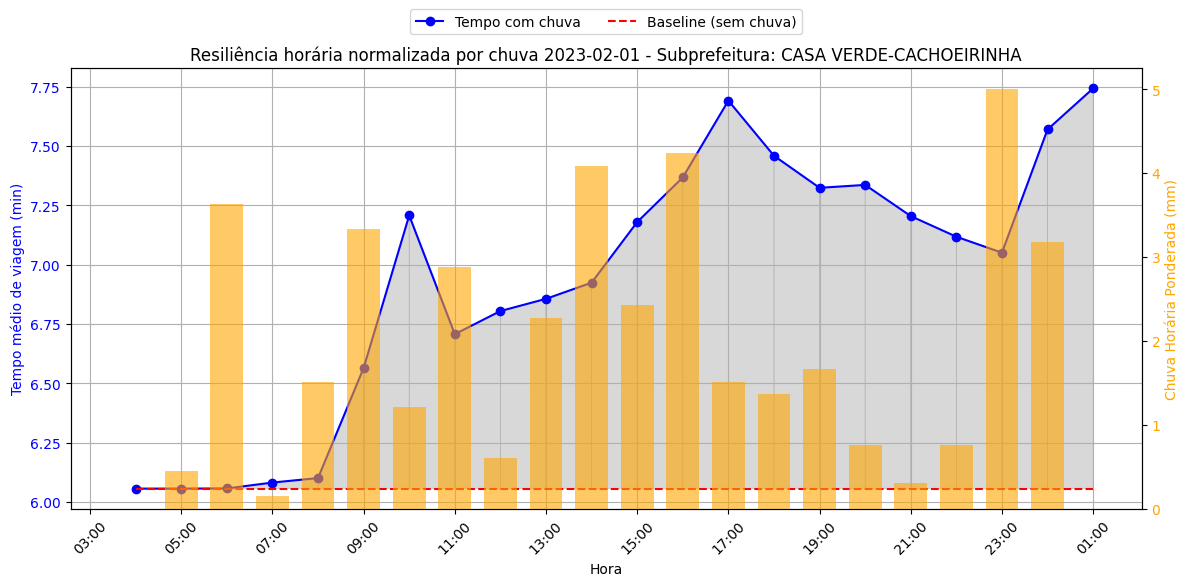

In [151]:
# Preparar os dados
tempo = df_chuva_periodo.index.to_numpy()
tt_chuva = resiliencia_df['tt_chuva'].values
tt_seco_mod = resiliencia_df['tt_seco_mod'].values

indices_normalizados = []
chuva_ponderada_por_hora = []

# Criar mapa de esta√ß√µes para a subprefeitura
dados_sp = df_final[df_final['Subprefeitura'] == nome_sp]
percentuais_estacoes = {}
for _, linha in dados_sp.iterrows():
    estacao_nome = linha['Esta√ß√£o']
    percentual = linha['Percentual da √Årea (%)']
    for idx, dados in dicionario_estacoes.items():
        if dados['Name'] == estacao_nome:
            estacao_id = dados['Estacao']
            percentuais_estacoes[estacao_id] = percentual
            break

# Iniciar gr√°fico
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(tempo, tt_chuva, marker='o', linestyle='-', color='b', label='Tempo com chuva')
ax1.plot(tempo, tt_seco_mod, linestyle='--', color='r', label='Baseline (sem chuva)')

# Loop principal: calcular e plotar
for i in range(len(tempo) - 1):
    x_trap = [tempo[i], tempo[i], tempo[i+1], tempo[i+1]]
    y_trap = [tt_seco_mod[i], tt_chuva[i], tt_chuva[i+1], tt_seco_mod[i+1]]
    base1 = abs(tt_chuva[i] - tt_seco_mod[i])
    base2 = abs(tt_chuva[i+1] - tt_seco_mod[i+1])
    area = 0.5 * (base1 + base2)

    # Chuva ponderada na hora i
    chuva_hora = df_chuva_periodo.iloc[i]
    chuva_ponderada = sum(chuva_hora.get(est_id, 0) * pct / 100 for est_id, pct in percentuais_estacoes.items())
    chuva_ponderada_por_hora.append(chuva_ponderada)

    indice = area / chuva_ponderada if chuva_ponderada > 0 else 0
    indices_normalizados.append(indice)

    # Desenhar o trap√©zio
    ax1.fill(x_trap, y_trap, color='gray', alpha=0.3, edgecolor='gray', linewidth=0.5)


# Ajustar eixo prim√°rio
ax1.set_title(f'Resili√™ncia hor√°ria normalizada por chuva {data_formatada} - Subprefeitura: {nome_sp}')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Tempo m√©dio de viagem (min)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Mostrar apenas a hora no eixo X
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Mostra de 2 em 2h
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Eixo secund√°rio: chuva hor√°ria
ax2 = ax1.twinx()
ax2.bar(tempo[:len(chuva_ponderada_por_hora)], chuva_ponderada_por_hora, 
        width=0.03, color='orange', alpha=0.6, label='Chuva Hor√°ria')
ax2.set_ylabel('Chuva Hor√°ria Ponderada (mm)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Legenda e mostrar
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)


plt.tight_layout()
plt.show()


In [152]:
# Calcular a √°rea total entre tt_chuva e tt_seco_mod
area_total = 0

for i in range(len(tempo) - 1):
    # Alturas dos trap√©zios (diferen√ßa entre curvas)
    base1 = abs(tt_chuva[i] - tt_seco_mod[i])
    base2 = abs(tt_chuva[i+1] - tt_seco_mod[i+1])

    # Largura (assumindo 1h entre os tempos; ou use real com timedelta)
    largura = 1  # ou (tempo[i+1] - tempo[i]).total_seconds() / 3600

    # √Årea do trap√©zio
    area_trap = 0.5 * (base1 + base2) * largura
    area_total += area_trap

print(f"√Årea total entre a curva com chuva e o baseline: {area_total:.2f} min¬∑hora")


√Årea total entre a curva com chuva e o baseline: 18.36 min¬∑hora
